In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **Imports**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import tqdm
import torchvision.models as models

In [ ]:
!pip install prophet
!pip isntall xgboost

# **Descarga de los datasets**

In [ ]:
train = pd.read_csv('./UH_2023_TRAIN.txt', sep = "|")
ETO_dataset = pd.read_csv('./DATOS_ETO.TXT', sep = "|")
METEO_dataset = pd.read_csv('./DATOS_METEO.TXT', sep = "|")

Una vez descargados todos los datasets, tenemos que adaptarlos para poder trabajar con ellos de la misma manera

#### DATASET TRAIN

Observamos como son las primeras columnas de nuestro dataset

In [ ]:
train_original = train.copy()
train.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.0,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0,20978.0
3,14,69671,340,4,520,32,2,0,1,0.0,40722.0
4,14,14001,852,14,NaN,81,1,0,1,0.0,14126.0


Ahora miramos de que tipo son nuestras variables

In [ ]:
train["MODO"] = train["MODO"]-1 #Vemos que modo varia entre 2 y 1, le restamos para pasarlo a binario
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601 entries, 0 to 9600
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPAÑA      9601 non-null   int64  
 1   ID_FINCA     9601 non-null   int64  
 2   ID_ZONA      9601 non-null   int64  
 3   ID_ESTACION  9601 non-null   int64  
 4   ALTITUD      9547 non-null   object 
 5   VARIEDAD     9601 non-null   int64  
 6   MODO         9601 non-null   int64  
 7   TIPO         9601 non-null   int64  
 8   COLOR        9601 non-null   int64  
 9   SUPERFICIE   9601 non-null   float64
 10  PRODUCCION   8526 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 825.2+ KB


La variable altitud es categorica cuando queremos que sea numérica debido a que hay algunos valores que estan en intervalo. Además tambien hay algunos valores NaN.

Primero de todo pasamos a numérico los valores, cogiendo el extremo inferior del intervalo, ya que la diferencia máxima entre extremo inferior y superior es de 50 metros, una diferencia no muy grande

Respecto a los NaN, se ha observado que la altura esta relacionada con la estación meteorologica a la que la finca pertenece y tambien en menor medida con la zona, por lo tanto ordenando el dataset por estos dos parámetros utilizamos los métodos ffill (que llena el NaN con el último valor visto) y bfill en caso que el valor NaN sea el primero (llena con el próximo valor que aparecera).

In [ ]:
train["ALTITUD"] = train["ALTITUD"].str[:3].apply(pd.to_numeric)
altitud_actualizada = train.sort_values(["ID_ESTACION","ID_ZONA"],
                                        na_position='last')['ALTITUD'].fillna(method='ffill').fillna(method="bfill")
train["ALTITUD"] = altitud_actualizada
del altitud_actualizada
train["ALTITUD"].isna().sum()

0

Se ha detectado que hay errores en los valores de superfície en las campañas 20, 21 y 22, donde hay valores que son 0 cuando no deberían serlo (se puede observar valores de producción altos en el valor 0), por lo tanto se tienen que corregir.
También se puede observar una cierta relación lineal respecto a la superfície y la producción, por lo tanto es importante tener estos valores.



<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

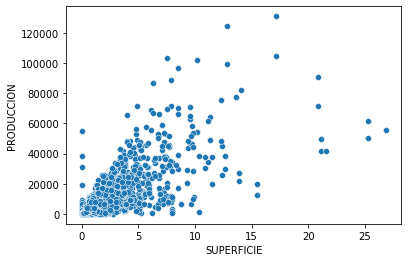

In [ ]:
train_superficie = train[(train["CAMPAÑA"] > 19)]
sns.scatterplot(data = train_superficie, x = "SUPERFICIE", y = "PRODUCCION")


In [ ]:
print(f'Superficies a 0 en la campaña 20 son {(train.loc[train.CAMPAÑA == 20]["SUPERFICIE"] == 0).sum()}')
print(f'Superficies a 0 en la campaña 21 son {(train.loc[train.CAMPAÑA == 21]["SUPERFICIE"] == 0).sum()}')
print(f'Superficies a 0 en la campaña 22 son {(train.loc[train.CAMPAÑA == 22]["SUPERFICIE"] == 0).sum()}')

Superficies a 0 en la campaña 20 son 13
Superficies a 0 en la campaña 21 son 20
Superficies a 0 en la campaña 22 son 9


Se ha optado para rellenar los valores haciendo un KNN, utilizando los valores 
de la producción, la estación a la que pertenece y la variedad de uva, ya que la estación y la variedad de uva dan información sobre el comportamiento climatológico del cultivo. También se ha usado altitud y modo, que están altamente correlacionadas con producción y podrían ayudar a conseguir un valor más preciso de superfície.
Para que la utilización de las estaciones tenga sentido, se ha segmentado por años, ya que cada estación guarda de manera intrínsica el comportamiento de la producción respecto a la climatología de un año en concreto solo.

Para hacer posible el uso del KNN se ha hecho OneHotEncoding con las variables ID_Estación y Variedad, y se ha hecho un MinMaxScaler de 0 a 2 con la producción, dándole una magnitud superior frente los demás datos ya que se ha visto en el plot cierta relación lineal entre la superfície y la producción, y el valor de correlación también nos indica esto, y uno de 0 a 1 para altitud.

In [ ]:
corregir_superficie_20 = train[train["CAMPAÑA"] == 20]
corregir_superficie_20 = pd.get_dummies(corregir_superficie_20, columns = ["ID_ESTACION","VARIEDAD"])
corregir_superficie_20["SUPERFICIE"].replace(0, np.nan, inplace=True)

corregir_superficie_20.corr()["PRODUCCION"]

CAMPAÑA                NaN
ID_FINCA          0.040940
ID_ZONA           0.005340
ALTITUD           0.117400
MODO              0.295574
TIPO              0.011333
COLOR             0.044247
SUPERFICIE        0.718068
PRODUCCION        1.000000
ID_ESTACION_0     0.015643
ID_ESTACION_2     0.067661
ID_ESTACION_3    -0.072868
ID_ESTACION_5    -0.062261
ID_ESTACION_6     0.132093
ID_ESTACION_7    -0.013574
ID_ESTACION_8    -0.021310
ID_ESTACION_9     0.044595
ID_ESTACION_10    0.088701
ID_ESTACION_11   -0.001971
ID_ESTACION_12   -0.162079
ID_ESTACION_13    0.064842
ID_ESTACION_14    0.041685
ID_ESTACION_15    0.049700
ID_ESTACION_16    0.093582
ID_ESTACION_18    0.043058
ID_ESTACION_19   -0.006479
VARIEDAD_4        0.039030
VARIEDAD_8        0.047212
VARIEDAD_9       -0.016869
VARIEDAD_10      -0.004307
VARIEDAD_15       0.069938
VARIEDAD_17      -0.086719
VARIEDAD_23      -0.012225
VARIEDAD_26       0.069391
VARIEDAD_32       0.191006
VARIEDAD_38       0.007555
VARIEDAD_40       0.008295
V

In [ ]:
corregir_superficie_20.drop(["CAMPAÑA","ID_FINCA","COLOR","TIPO","ID_ZONA"],axis=1,inplace=True)

Corregimos primero las superfícies de la campaña 20

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

scaler = MinMaxScaler(feature_range = (0, 2))
scaler.fit(corregir_superficie_20["PRODUCCION"].to_numpy().reshape(-1, 1))
corregir_superficie_20["PRODUCCION"] = scaler.transform(corregir_superficie_20["PRODUCCION"].to_numpy().reshape(-1, 1))

scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit(corregir_superficie_20["ALTITUD"].to_numpy().reshape(-1,1))
corregir_superficie_20["ALTITUD"]= scaler2.transform(corregir_superficie_20["ALTITUD"].to_numpy().reshape(-1,1))

imputer = KNNImputer(n_neighbors = 3)
corregir_superficie_20["SUPERFICIE"] = imputer.fit_transform(corregir_superficie_20)[:,2]

corregir_superficie_20["PRODUCCION"] = scaler.inverse_transform(corregir_superficie_20["PRODUCCION"].to_numpy().reshape(-1,1))
corregir_superficie_20["ALTITUD"] = scaler2.inverse_transform(corregir_superficie_20["ALTITUD"].to_numpy().reshape(-1,1))

train.loc[train.CAMPAÑA == 20, 'SUPERFICIE'] = corregir_superficie_20["SUPERFICIE"]


Proseguimos corrigiendo la campaña 21

In [ ]:
corregir_superficie_21 = train[train["CAMPAÑA"] == 21]
corregir_superficie_21 = corregir_superficie_21.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","TIPO","COLOR"], axis = 1)
corregir_superficie_21 = pd.get_dummies(corregir_superficie_21, columns=["ID_ESTACION","VARIEDAD"])
corregir_superficie_21["SUPERFICIE"].replace(0, np.nan, inplace=True)

scaler.fit(corregir_superficie_21["PRODUCCION"].to_numpy().reshape(-1,1))
corregir_superficie_21["PRODUCCION"] = scaler.transform(corregir_superficie_21["PRODUCCION"].to_numpy().reshape(-1,1))

scaler2.fit(corregir_superficie_21["ALTITUD"].to_numpy().reshape(-1,1))
corregir_superficie_21["ALTITUD"] = scaler2.transform(corregir_superficie_21["ALTITUD"].to_numpy().reshape(-1,1))

corregir_superficie_21["SUPERFICIE"] = imputer.fit_transform(corregir_superficie_21)[:,2]

corregir_superficie_21["PRODUCCION"] = scaler.inverse_transform(corregir_superficie_21["PRODUCCION"].to_numpy().reshape(-1,1))
corregir_superficie_21["ALTITUD"] = scaler2.inverse_transform(corregir_superficie_21["ALTITUD"].to_numpy().reshape(-1,1))

train.loc[train.CAMPAÑA == 21, 'SUPERFICIE'] = corregir_superficie_21["SUPERFICIE"]

Finalmente toca corregir los valores de la campaña 22.
Hemos observado que todos los 0 de la campaña 22 también son 0 en la 20 y la 21, por lo tanto se ha imputado su superfície en ambos casos. Dado que es más probable que la superfície se mantenga al largo de los años, como se puede ver en el histograma, hemos decidido que los valores de la superfície de estos casos sea la media de ambas predicciones.

<AxesSubplot:>

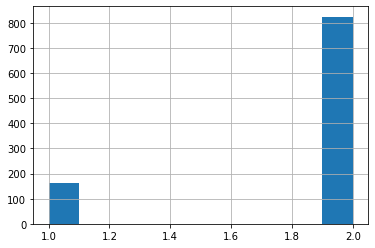

In [ ]:
corregir_superficie_21["ID_FINCA"] = train[train["CAMPAÑA"] == 21]["ID_FINCA"]
corregir_superficie_21["VARIEDAD"] = train[train["CAMPAÑA"] == 21]["VARIEDAD"]


corregir_superficie_20["ID_FINCA"] = train[train["CAMPAÑA"] == 20]["ID_FINCA"]
corregir_superficie_20["VARIEDAD"] = train[train["CAMPAÑA"] == 20]["VARIEDAD"]
keys = list(corregir_superficie_20[["ID_FINCA","VARIEDAD","MODO"]].columns.values)
i1 = corregir_superficie_20.set_index(keys).index
i2 = corregir_superficie_21.set_index(keys).index


igualtats_20 = corregir_superficie_20[["ID_FINCA","VARIEDAD","MODO","SUPERFICIE"]][i1.isin(i2)]
igualtats_21 = corregir_superficie_21[["ID_FINCA","VARIEDAD","MODO","SUPERFICIE"]][i2.isin(i1)]

aux = igualtats_20.copy()
aux = aux.append(igualtats_21)
aux = aux.groupby(["ID_FINCA","VARIEDAD","MODO","SUPERFICIE"]).size().reset_index().rename(columns = {0:'count'})
aux["count"].hist()

In [ ]:
igualtats_20["SUPERFICIE_21"] = train[train["CAMPAÑA"]==21]["SUPERFICIE"][i2.isin(i1)].values

igualtats_20["SUPERFICIE"] = igualtats_20[["SUPERFICIE","SUPERFICIE_21"]].mean(axis=1)
igualtats_21["SUPERFICIE"] = igualtats_20["SUPERFICIE"].values
train.loc[igualtats_20.index, "SUPERFICIE"] = igualtats_20["SUPERFICIE"]
train.loc[igualtats_21.index, "SUPERFICIE"] = igualtats_21["SUPERFICIE"]

<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

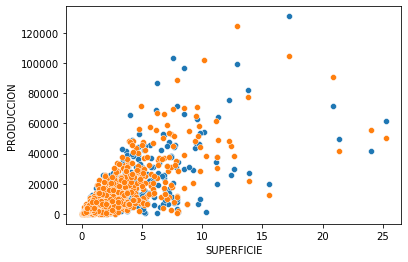

In [ ]:
sns.scatterplot(data = train.loc[train[train["CAMPAÑA"]==20].index], x = "SUPERFICIE", y = "PRODUCCION")
sns.scatterplot(data = train.loc[train[train["CAMPAÑA"]==21].index], x = "SUPERFICIE", y = "PRODUCCION")


Para hacer frente a los datos de superfície que faltan de la campaña 22, al no tener información sobre la producción no podemos utilizar un método parecido. Además se ha visto que la superfície de una misma finca puede variar mucho de un año a otro, por lo tanto no podemos rellenar con valores conocidos del año 20 y del 21 (misma razón por la que no podemos llenar el campo SUPERFICIE de las campañas anteriores a la 20 en este momento).

Aun así se ha visto que en bastantes casos la superfície se mantiene de un año para el otro, considerando que se cultiva la misma variedad (ya que de un año a otro no cambia el tipo de vid). Por lo tanto, para evitar cometer errores muy grandes en el valor de la superfície, que es un campo esencial para la producción, se ha rellenado el valor de la superfície calculando la media de las superfícies de la finca.

In [ ]:
corregir_superficie_22 = train[train["CAMPAÑA"] == 22]
corregir_superficie_22 = corregir_superficie_22[corregir_superficie_22["SUPERFICIE"] == 0]
keys = list(corregir_superficie_22[["ID_FINCA","VARIEDAD","MODO"]].columns.values)
i1 = corregir_superficie_22.set_index(keys).index
i2 = igualtats_20.set_index(keys).index
corregir_superficie_22["SUPERFICIE"] = (igualtats_20[i2.isin(i1)]["SUPERFICIE"]).values
train.loc[corregir_superficie_22.index, 'SUPERFICIE'] = corregir_superficie_22["SUPERFICIE"]

In [ ]:
print(f'Superficies a 0 en la campaña 20 son {(train.loc[train.CAMPAÑA == 20]["SUPERFICIE"] == 0).sum()}')
print(f'Superficies a 0 en la campaña 21 son {(train.loc[train.CAMPAÑA == 21]["SUPERFICIE"] == 0).sum()}')
print(f'Superficies a 0 en la campaña 22 son {(train.loc[train.CAMPAÑA == 22]["SUPERFICIE"] == 0).sum()}')

Superficies a 0 en la campaña 20 son 0
Superficies a 0 en la campaña 21 son 0
Superficies a 0 en la campaña 22 son 0


Solucionado el problema con las campañas 20, 21 y 22, ahora falta las demás campañas.

Sabemos que la gran mayoría de fincas mantienen la superfície al largo de los años, debido a que la vid es una planta que vive más de 50 años.
Por lo tanto, afrontaremos el problema en dos fases. Compararemos cada campaña con las campañas 20 y 21, comparando solo fincas que producen en ambos años (también teniendo en cuenta la variedad y el modo) y analizaremos la diferencia entre producciones de los años para ver si son producciones parecidas, lo que nos podría indicar climatología parecida y que podemos usar la campaña con superfícies conocidas como referencia. Luego, se hará un pequeño estudio estadístico para decidir si se puede considerar que la superfície se ha mantenido o no en base a la producción.

In [ ]:
campaña_21 = train[train["CAMPAÑA"] == 21] 
campaña_20 = train[train["CAMPAÑA"] == 20] 
campaña_15 = train[train["CAMPAÑA"] == 15] 
campaña_16 = train[train["CAMPAÑA"] == 16] 
campaña_17 = train[train["CAMPAÑA"] == 17] 
campaña_18 = train[train["CAMPAÑA"] == 18] 
campaña_19 = train[train["CAMPAÑA"] == 19] 
campaña_14 = train[train["CAMPAÑA"] == 14] 

keys = list(train[["ID_FINCA","VARIEDAD","MODO","ID_ESTACION","TIPO"]].columns.values)
i_14 = campaña_14.set_index(keys).index
i_20 = campaña_20.set_index(keys).index
i_21 = campaña_21.set_index(keys).index
i_15 = campaña_15.set_index(keys).index
i_16 = campaña_16.set_index(keys).index
i_17 = campaña_17.set_index(keys).index
i_18 = campaña_18.set_index(keys).index
i_19 = campaña_19.set_index(keys).index

No utilizaremos las estaciones con poca cantidad de fincas, ya que no tienen relevancia estadística y no se pueden normalizar las diferencias respecto las estaciones.

In [ ]:
sub_train = train[train["CAMPAÑA"] < 22].copy()
terrenos = sub_train[["ID_FINCA","VARIEDAD","MODO","ID_ESTACION","TIPO"]].drop_duplicates()
terrenos["ID_ESTACION"].value_counts()

12    426
5     243
7     237
16    183
15    173
19    161
18    152
14    105
10     68
9      39
3      39
8      18
6       7
2       5
4       4
11      4
17      4
0       2
13      2
1       1
Name: ID_ESTACION, dtype: int64

Creamos un dataset auxiliar que nos permita comparar campañas y tomar decisiones si los valores de una finca son parecidos a los de la campaña 20 y/o 21

In [ ]:
terrenos = terrenos[(terrenos.ID_ESTACION != 1) & (terrenos.ID_ESTACION != 13) & (terrenos.ID_ESTACION != 0)
                   & (terrenos.ID_ESTACION != 17) & (terrenos.ID_ESTACION != 11) & (terrenos.ID_ESTACION != 4)
                    & (terrenos.ID_ESTACION != 2) & (terrenos.ID_ESTACION != 6) & (terrenos.ID_ESTACION != 8)]
i_terrenos = terrenos.set_index(keys).index


In [ ]:
#14   
terrenos = terrenos.merge(campaña_14[i_14.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_14"})
#15
terrenos = terrenos.merge(campaña_15[i_15.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_15"})
#16
terrenos = terrenos.merge(campaña_16[i_16.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_16"})
#17
terrenos = terrenos.merge( campaña_17[i_17.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_17"})
#18
terrenos = terrenos.merge( campaña_18[i_18.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_18"})
#19
terrenos = terrenos.merge(campaña_19[i_19.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_19"})
#20
terrenos = terrenos.merge( campaña_20[i_20.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','SUPERFICIE','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_20", "SUPERFICIE":"SUPERFICIE_20"})
#21
terrenos = terrenos.merge( campaña_21[i_21.isin(i_terrenos)][['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','PRODUCCION','SUPERFICIE','TIPO']], how='left',on = ['ID_FINCA','VARIEDAD','MODO','ID_ESTACION','TIPO'])
terrenos = terrenos.rename(columns={"PRODUCCION":"PRODUCCION_21","SUPERFICIE":"SUPERFICIE_21"})
terrenos = terrenos.fillna(0)

Creamos un nuevo dataset auxiliar para guardar las diferencias

In [ ]:
aux = terrenos.copy()
aux["DIF_14_20"] = 0
aux["DIF_15_20"] = 0
aux["DIF_16_20"] = 0
aux["DIF_17_20"] = 0
aux["DIF_18_20"] = 0
aux["DIF_19_20"] = 0
aux["DIF_14_21"] = 0
aux["DIF_15_21"] = 0
aux["DIF_16_21"] = 0
aux["DIF_17_21"] = 0
aux["DIF_18_21"] = 0
aux["DIF_19_21"] = 0

Comparamos que la varianza es igual para la misma estación en campañas diferentes (comparando todas con la 20 y 21) con un test estadístico de Levene. En caso de que haya similitud en la varianza, lo que nos podría indicar situaciones climatológicas no muy diferentes, calculamos la diferencia de producción entre las fincas que aparecen en ambas campañas normalizando.
Hemos optado por un threshold del p-value de 0.2, para evitar errores muy grandes

In [ ]:
import scipy
from numpy import inf

for i in np.unique(terrenos.ID_ESTACION.values):
    #Cogemos las producciones de cada año respecto su estación
    prod_20 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_20"]
    prod_21 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_21"]

    #CAMPAÑA 14
    prod_14 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_14"]
    #Si el pvalor del test estadístico de Levene es mayor a 0.2, 
    #calculamos el porcentaje de diferencia entre campañas y normalizamos.
    #Añadimos el valor absoluto al final para facilitar los cálculos posteriores
    if(scipy.stats.levene(prod_14[prod_14!=0],prod_20[prod_20!=0]).pvalue>0.2):
        diferencias_20 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_14"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_20"]
        diferencias_20[diferencias_20 == inf]=0
        normalizado_20 = (diferencias_20[diferencias_20!=0] - np.mean(diferencias_20[diferencias_20!=0]))/np.std(diferencias_20[diferencias_20!=0])
        aux.loc[normalizado_20.index,"DIF_14_20"] = np.abs(normalizado_20.fillna(0))
        
    if(scipy.stats.levene(prod_14[prod_14!=0],prod_21[prod_21!=0]).pvalue>0.2):
        diferencias_21 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_14"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_21"]
        diferencias_21[diferencias_21 == inf]=0
        normalizado_21 = (diferencias_21[diferencias_21!=0] - np.mean(diferencias_21[diferencias_21!=0]))/np.std(diferencias_21[diferencias_21!=0])
        aux.loc[normalizado_21.index,"DIF_14_21"] = np.abs(normalizado_21.fillna(0))
    
    #CAMPAÑA 15
    prod_15 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_15"]
    if(scipy.stats.levene(prod_15[prod_15 != 0],prod_20[prod_20 != 0]).pvalue > 0.2):
        diferencias_20 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_15"] / terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_20"]
        diferencias_20[diferencias_20 == inf] = 0
        normalizado_20 = (diferencias_20[diferencias_20 != 0] - np.mean(diferencias_20[diferencias_20 != 0])) / np.std(diferencias_20[diferencias_20 != 0])
        aux.loc[normalizado_20.index,"DIF_15_20"] = np.abs(normalizado_20.fillna(0))
    
    
    if(scipy.stats.levene(prod_15[prod_15!=0],prod_21[prod_21!=0]).pvalue > 0.2):
        diferencias_21 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_15"] / terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_21"]
        diferencias_21[diferencias_21 == inf] = 0
        normalizado_21 = (diferencias_21[diferencias_21 != 0] - np.mean(diferencias_21[diferencias_21 != 0]))/np.std(diferencias_21[diferencias_21 != 0])
        aux.loc[normalizado_21.index,"DIF_15_21"] = np.abs(normalizado_21.fillna(0))
    
    #CAMPAÑA 16
    prod_16 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_16"]
    if(scipy.stats.levene(prod_16[prod_16!=0],prod_20[prod_20 != 0]).pvalue > 0.2):
        diferencias_20 = terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_16"]/ terrenos[terrenos["ID_ESTACION"] == i]["PRODUCCION_20"]
        diferencias_20[diferencias_20 == inf]=0
        normalizado_20 = (diferencias_20[diferencias_20!=0] - np.mean(diferencias_20[diferencias_20!=0]))/np.std(diferencias_20[diferencias_20!=0])
        aux.loc[normalizado_20.index,"DIF_16_20"] = np.abs(normalizado_20.fillna(0))
    
    if(scipy.stats.levene(prod_16[prod_16!=0],prod_21[prod_21!=0]).pvalue>0.2):
        diferencias_21 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_16"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_21"]
        diferencias_21[diferencias_21 == inf]=0
        normalizado_21 = (diferencias_21[diferencias_21!=0] - np.mean(diferencias_21[diferencias_21!=0]))/np.std(diferencias_21[diferencias_21!=0])
        aux.loc[normalizado_21.index,"DIF_16_21"] = np.abs(normalizado_21.fillna(0))
   
    #CAMPAÑA 17
    prod_17 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_17"]
    if(scipy.stats.levene(prod_17[prod_17!=0],prod_20[prod_20!=0]).pvalue>0.2):
        diferencias_20 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_17"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_20"]
        diferencias_20[diferencias_20 == inf]=0
        normalizado_20 = (diferencias_20[diferencias_20!=0] - np.mean(diferencias_20[diferencias_20!=0]))/np.std(diferencias_20[diferencias_20!=0])
        aux.loc[normalizado_20.index,"DIF_17_20"] = np.abs(normalizado_20.fillna(0))
    
    
    if(scipy.stats.levene(prod_17[prod_17!=0],prod_21[prod_21!=0]).pvalue>0.2):
        diferencias_21 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_17"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_21"]
        diferencias_21[diferencias_21 == inf]=0
        normalizado_21 = (diferencias_21[diferencias_21!=0] - np.mean(diferencias_21[diferencias_21!=0]))/np.std(diferencias_21[diferencias_21!=0])
        aux.loc[normalizado_21.index,"DIF_17_21"] = np.abs(normalizado_21.fillna(0))
    
    #CAMPAÑA 18
    prod_18 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_18"]
    if(scipy.stats.levene(prod_18[prod_18!=0],prod_20[prod_20!=0]).pvalue>0.2):
        diferencias_20 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_18"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_20"]
        diferencias_20[diferencias_20 == inf]=0
        normalizado_20 = (diferencias_20[diferencias_20!=0] - np.mean(diferencias_20[diferencias_20!=0]))/np.std(diferencias_20[diferencias_20!=0])
        aux.loc[normalizado_20.index,"DIF_18_20"] = np.abs(normalizado_20.fillna(0))
    
    
    if(scipy.stats.levene(prod_18[prod_18!=0],prod_21[prod_21!=0]).pvalue>0.2):
        diferencias_21 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_18"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_21"]
        diferencias_21[diferencias_21 == inf]=0
        normalizado_21 = (diferencias_21[diferencias_21!=0] - np.mean(diferencias_21[diferencias_21!=0]))/np.std(diferencias_21[diferencias_21!=0])
        aux.loc[normalizado_21.index,"DIF_18_21"] = np.abs(normalizado_21.fillna(0))
    
    #CAMPAÑA 19
    prod_19 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_19"]
    if(scipy.stats.levene(prod_19[prod_19!=0],prod_20[prod_20!=0]).pvalue>0.2):
        diferencias_20 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_19"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_20"]
        diferencias_20[diferencias_20 == inf]=0
        normalizado_20 = (diferencias_20[diferencias_20!=0] - np.mean(diferencias_20[diferencias_20!=0]))/np.std(diferencias_20[diferencias_20!=0])
        aux.loc[normalizado_20.index,"DIF_19_20"] = np.abs(normalizado_20.fillna(0))
    
    
    if(scipy.stats.levene(prod_19[prod_19!=0],prod_21[prod_21!=0]).pvalue>0.2):
        diferencias_21 = terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_19"]/ terrenos[terrenos["ID_ESTACION"]==i]["PRODUCCION_21"]
        diferencias_21[diferencias_21 == inf]=0
        normalizado_21 = (diferencias_21[diferencias_21!=0] - np.mean(diferencias_21[diferencias_21!=0]))/np.std(diferencias_21[diferencias_21!=0])
        aux.loc[normalizado_21.index,"DIF_19_21"] = np.abs(normalizado_21.fillna(0))
    

In [ ]:
aux = aux.drop(["PRODUCCION_14","PRODUCCION_15","PRODUCCION_16","PRODUCCION_17",
                "PRODUCCION_18","PRODUCCION_19","PRODUCCION_20","PRODUCCION_21"],axis=1)
#Evitamos reemplazar los 0 de MODO y TIPO por NaN
aux_modos = aux["MODO"] 
aux_tipo = aux["TIPO"]
aux.replace(0, np.nan, inplace=True)
aux["MODO"] = aux_modos
aux["TIPO"]= aux_tipo


In [ ]:
train_bo = train.copy()
train_bo.SUPERFICIE.replace(0,np.nan,inplace=True)
train_bo["SUPERFICIE"].isnull().sum()

6476

En el dataset auxiliar tenemos una tabla que nos indica que tan parecida es la producción de una finca con sus valores de de las campañas 20 y 21. Consideramos que si la diferencia es menor que 1 la superfície es igual (siguiendo la regla empírica de 68-95-99.7, optando aquí por el 68 que corresponde al 1).

In [ ]:
for i in aux.values:
    
    if i[7] < 1:
        train_bo.loc[(train_bo.CAMPAÑA == 14) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[5]
    elif i[13]< 1:
        train_bo.loc[(train_bo.CAMPAÑA == 14) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[6]
    if i[8] < 1:
        train_bo.loc[(train_bo.CAMPAÑA == 15) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[5]
    elif i[14]< 1:
        train_bo.loc[(train_bo.CAMPAÑA == 15) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[6]
    if i[9] < 1:
        train_bo.loc[(train_bo.CAMPAÑA == 16) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[5]
    elif i[15]< 1:
        train_bo.loc[(train_bo.CAMPAÑA == 16) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[6]
    if i[10] < 1:
        train_bo.loc[(train_bo.CAMPAÑA == 17) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[5]
    elif i[16]< 1:
        train_bo.loc[(train_bo.CAMPAÑA == 17) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[6]
    if i[11] < 1:
        train_bo.loc[(train_bo.CAMPAÑA == 18) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[5]
    elif i[17]< 1:
        train_bo.loc[(train_bo.CAMPAÑA == 18) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[6]
    if i[12] < 1:
        train_bo.loc[(train_bo.CAMPAÑA == 19) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[5]
    elif i[18]< 1:
        train_bo.loc[(train_bo.CAMPAÑA == 19) & (train_bo.ID_FINCA == i[0]) & (train_bo.VARIEDAD == i[1])
                    & (train_bo.MODO == i[2]) & (train_bo.ID_ESTACION == i[3]) 
                     & (train_bo.TIPO == i[4]), 'SUPERFICIE'] = i[6]

In [ ]:
train_bo["SUPERFICIE"].isnull().sum()

3176

Observando un par de ejemplos y el plot de superfície y predicción (comparando con la campaña 20 y 21), parece que la metodología es efectiva.

In [ ]:
train_bo[train["ID_FINCA"]==98814]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
13,14,98814,919,14,650.0,32,1,0,1,7.1657,31496.5
14,14,98814,919,14,650.0,40,1,0,1,3.5000,16990.0
1160,15,98814,919,14,650.0,40,1,0,1,3.5000,16100.0
2270,16,98814,919,14,650.0,32,1,0,1,7.1657,34670.0
2271,16,98814,919,14,650.0,40,1,0,1,3.5000,12110.0
3348,17,98814,919,14,650.0,40,1,0,1,3.5000,9420.0
4365,18,98814,919,14,650.0,32,1,0,1,7.1657,39050.0
4366,18,98814,919,14,650.0,40,1,0,1,3.5000,11710.0
5425,19,98814,919,14,650.0,32,1,0,1,7.1657,63170.0
5426,19,98814,919,14,650.0,40,1,0,1,3.5000,25690.0


In [ ]:
train_bo[train["ID_FINCA"]==48093]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
1159,15,48093,919,14,650.0,59,1,0,1,1.777333,12222.144
2269,16,48093,919,14,650.0,59,1,0,1,1.777333,6686.064
3347,17,48093,919,14,650.0,59,1,0,1,1.777333,4911.984
4364,18,48093,919,14,650.0,59,1,0,1,1.777333,4542.912
5424,19,48093,919,14,650.0,59,1,0,1,1.777333,8620.128
6479,20,48093,919,14,650.0,59,1,0,1,1.777333,2347.488
7486,21,48093,919,14,650.0,59,1,0,1,1.777333,4344.912


In [ ]:
train_bo[train["ID_FINCA"]==5696]

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
12,14,5696,919,14,650.0,59,0,0,1,NaN,21907.6
1158,15,5696,919,14,650.0,59,0,0,1,7.62,22136.4
2268,16,5696,919,14,650.0,59,0,0,1,7.62,11294.4
3346,17,5696,919,14,650.0,59,0,0,1,7.62,6744.4
4363,18,5696,919,14,650.0,59,0,0,1,7.62,930.8
5423,19,5696,919,14,650.0,59,0,0,1,7.62,10894.0
6478,20,5696,919,14,650.0,59,0,0,1,7.62,7092.8
7485,21,5696,919,14,650.0,59,0,0,1,7.62,7800.0
8528,22,5696,919,14,650.0,59,0,0,1,7.62,NaN


<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

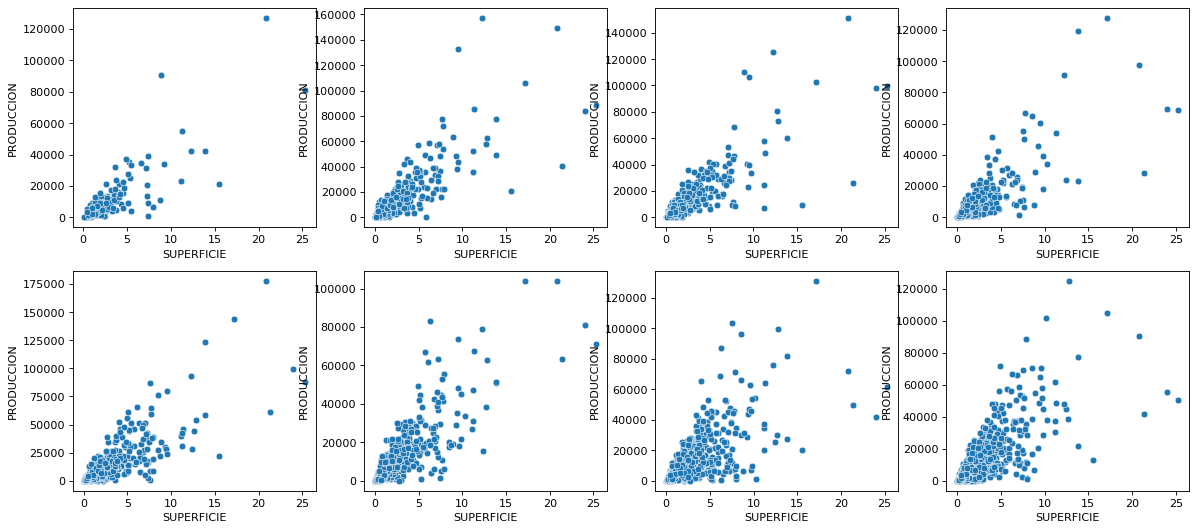

In [ ]:
plt.figure(figsize=(18, 8), dpi=80)

plt.subplot(2, 4, 1)

sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==14], x="SUPERFICIE", y="PRODUCCION")

plt.subplot(2, 4, 2)

sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==15], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 3)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==16], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2,4, 4)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==17], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 5)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==18], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 6)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==19], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 7)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==20], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 8)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==21], x="SUPERFICIE", y="PRODUCCION")

Hemos conseguido reducir los valores desconocidos a menos de la mitad haciendo esta prueba estadística, y los gráficos muestran parecidos con los de las campañas 20 y 21, donde conocemos la superficie. Aun así, quedan muchos valores a 0 aún como para plantearse utilizar algún método de imputación o de rellenar valores.

El siguiente método es menos matemático y más centrado en el pragmatismo. 
Por un lado miraremos los valores de superfície que hemos llenado, es decir ignoraremos las campañas 
Compararemos los valores de producción de las superfícies desconocidas con la de las producciones 20 y 21, y si vemos que tienen producciónes parecidas, añadiremos la superfície. También llenaremos si vemos que la superfície se repite cada año y es representativo (es decir en más de un año la superfície és igual).

In [ ]:
superficie_null = train_bo[train_bo["SUPERFICIE"].isnull()]
superficie_nonull = train_bo[(train_bo["SUPERFICIE"]>0) & (train_bo["CAMPAÑA"]<22)]
i_null = superficie_null.set_index(keys).index
i_nonull = superficie_nonull.set_index(keys).index

superficie_null=(superficie_null[i_null.isin(i_nonull)]).drop(["ID_ZONA","ALTITUD","COLOR"],axis=1)
superficie_nonull=superficie_nonull[i_nonull.isin(i_null)].drop(["CAMPAÑA","ID_ZONA","ALTITUD","COLOR"],axis=1)

In [ ]:
for i in superficie_null.values:    
    prod_sup = superficie_nonull.loc[(superficie_nonull.ID_FINCA == i[1]) & (superficie_nonull.VARIEDAD == i[3])
                    & (superficie_nonull.MODO == i[4]) & (superficie_nonull.ID_ESTACION == i[2]) 
                     & (superficie_nonull.TIPO == i[5]), ["PRODUCCION","SUPERFICIE"]]
    minimo = np.abs(prod_sup["PRODUCCION"] - i[-1]).min() #Resultado mas parecido entre producción de superfície desconocida y conocida
    index = np.argmin(np.abs(prod_sup["PRODUCCION"] - i[-1]))
    #Si la producción no ha variado en un 50% o la superfície es igual para todas las fincas y hay más de 3 casos, llenamos con esa superf´cie
    if(minimo/prod_sup["PRODUCCION"].values[index] < 0.6) or (((prod_sup["SUPERFICIE"]).min() == prod_sup["SUPERFICIE"].max()) and (len(prod_sup["SUPERFICIE"])>3)):
        train_bo.loc[(train_bo.CAMPAÑA == i[0]) &  (train_bo.ID_FINCA == i[1]) & (train_bo.VARIEDAD == i[3])
                    & (train_bo.MODO == i[4]) & (train_bo.ID_ESTACION == i[2]) 
                     & (train_bo.TIPO == i[5]), 'SUPERFICIE'] = prod_sup["SUPERFICIE"].values[index]

Reevaluamos los NaNs que nos quedan y llenamos ahora teniendo en cuenta los valores de superfície de la campaña 22. Si hay una finca sin superfície que aparece en la campaña 22, le damos esa superfície, ya que las fincas son propensas a mantener la superfície, como se ha visto anteriormente

In [ ]:
superficie_null = train_bo[train_bo["SUPERFICIE"].isnull()]
superficie_nonull = train_bo[(train_bo["SUPERFICIE"]>0) & (train_bo["CAMPAÑA"]<22)]
superficie_nonull_22 = train_bo[(train_bo["SUPERFICIE"]>0) & (train_bo["CAMPAÑA"]==22)]
i_null = superficie_null.set_index(keys).index
i_nonull = superficie_nonull.set_index(keys).index
i_nonull_22 = superficie_nonull_22.set_index(keys).index
train_bo["SUPERFICIE"].isnull().sum()

1969

In [ ]:
superficie_null = superficie_null[i_null.isin(i_nonull_22)]
llista = []
for x,index in zip(superficie_null.values,superficie_null.index):
    valor =  superficie_nonull_22.loc[(superficie_nonull_22.ID_FINCA == x[1]) & (superficie_nonull_22.VARIEDAD == x[5])
                       & (superficie_nonull_22.MODO == x[6]) & (superficie_nonull_22.TIPO == x[7]),"SUPERFICIE"]
    superficie_null.loc[(superficie_null.CAMPAÑA==x[0]) & (superficie_null.ID_FINCA == x[1]) & (superficie_null.VARIEDAD == x[5])
                       & (superficie_null.MODO == x[6]) & (superficie_null.TIPO == x[7]),"SUPERFICIE"] = valor.values[0]

In [ ]:
train_bo.loc[superficie_null.index,"SUPERFICIE"] = superficie_null["SUPERFICIE"]
train_bo["SUPERFICIE"].isnull().sum()

1802

<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

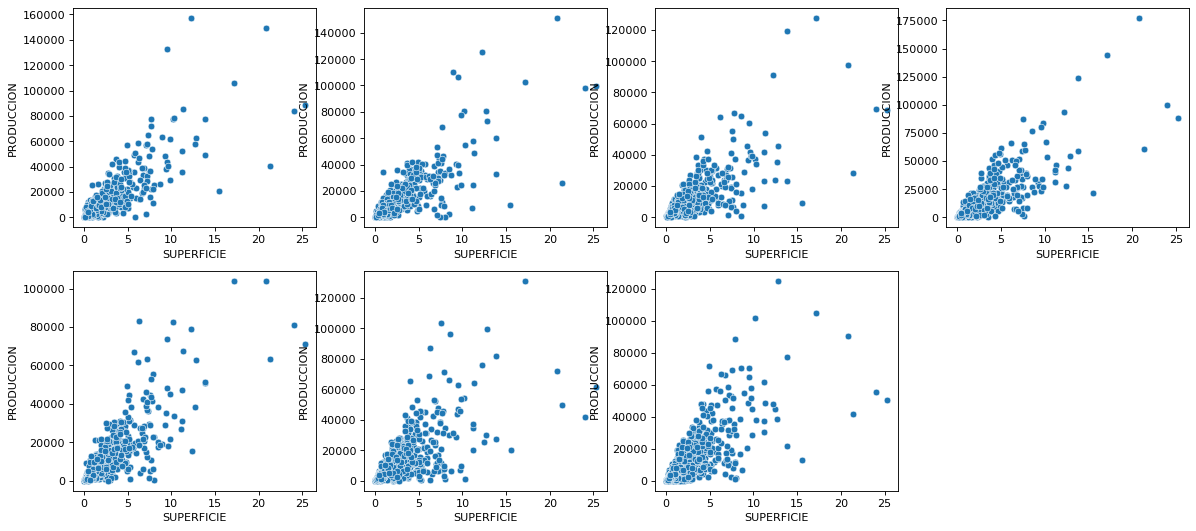

In [ ]:
plt.figure(figsize=(18, 8), dpi=80)

plt.subplot(2, 4, 1)

sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==15], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 2)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==16], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2,4, 3)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==17], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 4)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==18], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 5)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==19], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 6)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==20], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 7)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==21], x="SUPERFICIE", y="PRODUCCION")


Si bien es cierto que se ve algún valor un poco sospechoso de ser outlier debido a una mala imputación de la superfície, en general la metodología parece correcta

Queda por rellenar el 28% de las superfícies. Aunque es una cifra significativa, al haber conseguido los demás valores de una manera razonable estadísticamente hablando y las gráficas lo demuestran, hacer un KNN imputation como anteriormente se ha hecho es viable y no debería causar error. Como antes diviremos por campañas.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,2))
scaler2 = MinMaxScaler(feature_range=(0,1))
imputer = KNNImputer(n_neighbors=5)

def corregir_superficie_2(data,año):
    data = data[data["CAMPAÑA"] == año]
    data = pd.get_dummies(data, columns = ["ID_ESTACION","VARIEDAD"])
    data["SUPERFICIE"].replace(0, np.nan, inplace=True)
    data.drop(["CAMPAÑA","ID_FINCA","COLOR","TIPO","ID_ZONA"],axis=1,inplace=True)
    scaler.fit(data["PRODUCCION"].to_numpy().reshape(-1, 1))
    data["PRODUCCION"] = scaler.transform(data["PRODUCCION"].to_numpy().reshape(-1, 1))
    scaler2.fit(data["ALTITUD"].to_numpy().reshape(-1,1))
    data["ALTITUD"]= scaler2.transform(data["ALTITUD"].to_numpy().reshape(-1,1))
    imputer = KNNImputer(n_neighbors = 3)
    data["SUPERFICIE"] = imputer.fit_transform(data)[:,2]
    train_bo.loc[train_bo.CAMPAÑA == año, 'SUPERFICIE'] = data["SUPERFICIE"]

train_bo_copia = train_bo.copy()
#Evitamos imputar con los nuevos valores añadidos
corregir_superficie_2(train_bo_copia.copy(),14)
corregir_superficie_2(train_bo_copia.copy(),15)
corregir_superficie_2(train_bo_copia.copy(),16)
corregir_superficie_2(train_bo_copia.copy(),17)
corregir_superficie_2(train_bo_copia.copy(),18)
corregir_superficie_2(train_bo_copia.copy(),19)

In [ ]:
train_bo["SUPERFICIE"].isnull().sum()

0

<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

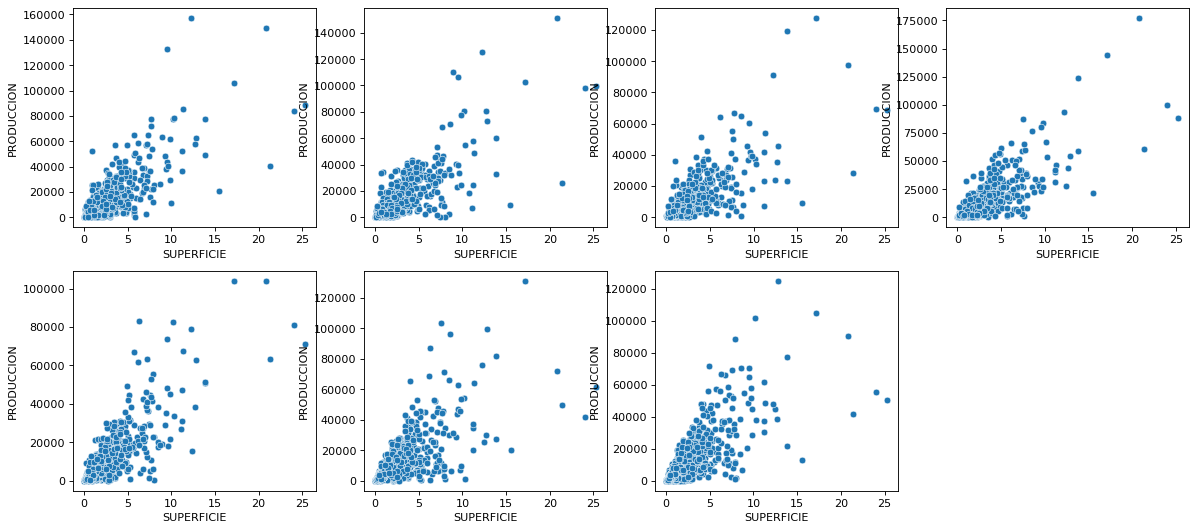

In [ ]:
plt.figure(figsize=(18, 8), dpi=80)

plt.subplot(2, 4, 1)

sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==15], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 2)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==16], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2,4, 3)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==17], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 4)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==18], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 5)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==19], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 6)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==20], x="SUPERFICIE", y="PRODUCCION")
plt.subplot(2, 4, 7)
sns.scatterplot(data = train_bo.loc[train_bo.CAMPAÑA==21], x="SUPERFICIE", y="PRODUCCION")

Se obtiene unos plots de la relación superfície producción bastante parecidos a las campañas 20 y 21 (los dos últimos plots)

### Distribución de las variables

Para facilitar el estudio dividiremos en dataset que se usara para predecir la campaña 22 y un dataset exclusivo de la campaña 22

In [ ]:
train_models = train_bo[train_bo["CAMPAÑA"]<22]
train_22 = train_bo[train_bo["CAMPAÑA"]==22]

Primero de todo observamos que nuestra variable objetivo parece comportarse como una chi cuadrada o una distribución normal right-skewed. No nos debería afectar de cara al ouput, no és una distribución extremadamente rara.

(array([6170., 1337.,  490.,  250.,  116.,   56.,   38.,   19.,   16.,
          10.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

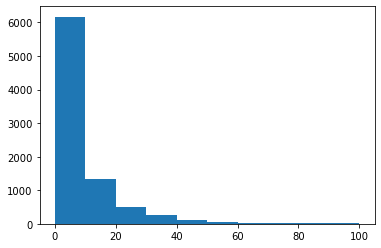

In [ ]:
plt.hist(train_models["PRODUCCION"]/1000, range=[0, 100])

Respecto a la superfície, podemos observar como sigue una distribución muy parecida a la variable objetivo (de ahí su alta correlación), y hay una proporción parecida en el set de predicción.

<AxesSubplot:>

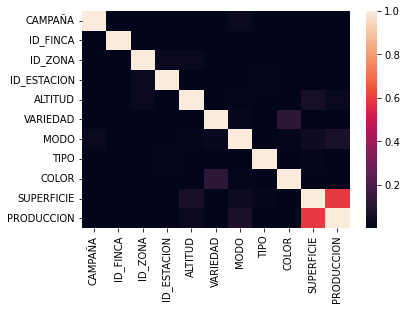

In [ ]:
sns.heatmap(train_models.corr()**2)

<AxesSubplot:>

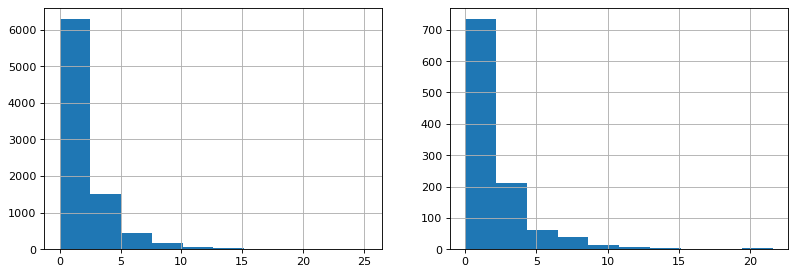

In [ ]:
plt.figure(figsize=(12, 4), dpi=80)

plt.subplot(1, 2, 1)
train_models["SUPERFICIE"].hist()
plt.subplot(1, 2, 2)
train_22["SUPERFICIE"].hist()


De cara a futuros modelos donde nos interese normalizar, nos puede ser de interés que nuestra variable superfície siga una distribución normal. Para ello hacemos una transformación Box-Cox, y si más adelante hiciera falta se podría recuperar (que se verá más adelante que no se ha dado el caso de necesitarlo)

<AxesSubplot:>

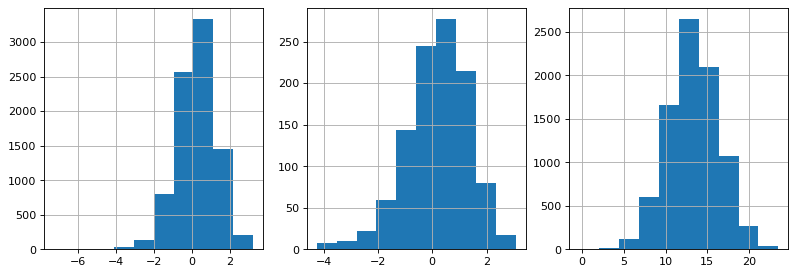

In [ ]:
plt.figure(figsize=(12, 4), dpi=80)
from scipy.special import boxcox, inv_boxcox

train_models["SUPERFICIE"] = boxcox(train_models["SUPERFICIE"] , 0)
train_22["SUPERFICIE"] = boxcox(train_22["SUPERFICIE"] , 0)
train_models["PRODUCCION"] = boxcox(train_models["PRODUCCION"] , 0.1)

plt.subplot(1, 3, 1)
train_models["SUPERFICIE"].hist()
plt.subplot(1, 3, 2)
train_22["SUPERFICIE"].hist()
plt.subplot(1, 3, 3)
train_models["PRODUCCION"].hist()

Tenemos la posibilidad de trabajar con los datos en forma de distribución normal si es necesario. Aun así, recuperamos la versión original ya que la similitud de la distribución original de superfície y producción nos puede ser más beneficiosa a la hora de modelar.

In [ ]:
def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))
train_models["SUPERFICIE"] = invboxcox(train_models["SUPERFICIE"] , 0)
train_22["SUPERFICIE"] = invboxcox(train_22["SUPERFICIE"] , 0)
train_models["PRODUCCION"] = invboxcox(train_models["PRODUCCION"] , 0.1)


En el caso de la variable variedad, vemos que la proporcion se respeta mayoritáriamente, y no tendremos que aplicar ningún método de balanceo, como por ejemplo podría ser SMOTE.

<AxesSubplot:>

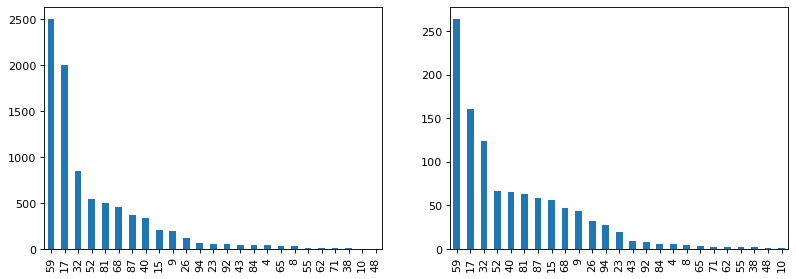

In [ ]:
plt.figure(figsize=(12, 4), dpi=80)

plt.subplot(1, 2, 1)
train_models["VARIEDAD"].value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)

train_22["VARIEDAD"].value_counts().plot(kind='bar')

Procedemos con la variable Altitud. Se ve un cierto desbalanceo, y parece ser que sigue una distribución multimodal. Aun así, parece una proporcion medianamente parecida al la de la predicción, por lo tanto optamos por no modificar nada.

<AxesSubplot:>

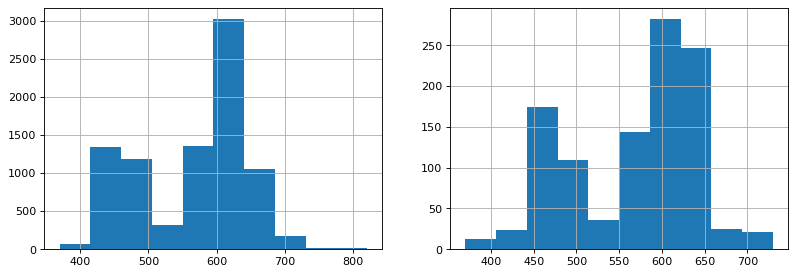

In [ ]:
plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(1, 2, 1)
train_models["ALTITUD"].hist()
plt.subplot(1, 2, 2)
train_22["ALTITUD"].hist()

Por lo que respeta a nuestras variables binárias (e ignorando color, ninguna variedad repite color), vemos que la proporción se mantiene en el atributo TIPO, que está muy desbalanceado, y en el caso de MODO no se mantiene del todo pero en el dataset que se utilizará de entrenamiento es proporcional, por lo tanto no debería haber error.
Debido al desbalanceo de la variable tipo, miramos si afecta mucho a nuestra variable objetivo y vemos que hay una diferencia considerable, que se puede mirar de tener en cuenta más adelante.

<AxesSubplot:>

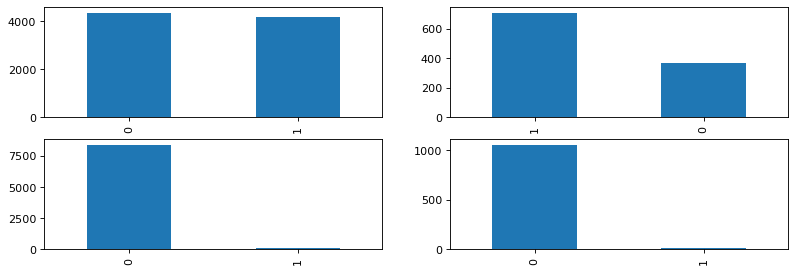

In [ ]:
plt.figure(figsize=(12, 4), dpi=80)

plt.subplot(2, 2, 1)
train_models["MODO"].value_counts().plot(kind='bar')
plt.subplot(2, 2, 2)
train_22["MODO"].value_counts().plot(kind='bar')
plt.subplot(2, 2, 3)
train_models["TIPO"].value_counts().plot(kind='bar')
plt.subplot(2, 2, 4)
train_22["TIPO"].value_counts().plot(kind='bar')


Miremos ahora como varia la producción según tipo de suelo y modo de cultivo:

In [ ]:
print("Produccion media TIPO 0:",np.mean(train_models[train_models["TIPO"]==0]["PRODUCCION"]/train_models[train_models["TIPO"]==0]["SUPERFICIE"]))
print("Produccion media TIPO 1:",np.mean(train_models[train_models["TIPO"]==1]["PRODUCCION"]/train_models[train_models["TIPO"]==1]["SUPERFICIE"]))
print("Produccion media MODO 0:",np.mean(train_models[train_models["MODO"]==0]["PRODUCCION"]/train_models[train_models["MODO"]==0]["SUPERFICIE"]))
print("Produccion media MODO 1:",np.mean(train_models[train_models["MODO"]==1]["PRODUCCION"]/train_models[train_models["MODO"]==1]["SUPERFICIE"]))
print()
print("Produccion media TIPO 0 MODO 0:",np.mean(train_models[(train_models["TIPO"]==0) & (train_models["MODO"]==0)]["PRODUCCION"]/train_models[(train_models["TIPO"]==0) & (train_models["MODO"]==0)]["SUPERFICIE"])) 
print("Produccion media TIPO 0 MODO 1:",np.mean(train_models[(train_models["TIPO"]==0) & (train_models["MODO"]==1)]["PRODUCCION"]/train_models[(train_models["TIPO"]==0) & (train_models["MODO"]==1)]["SUPERFICIE"]))
print("Produccion media TIPO 1 MODO 0:",np.mean(train_models[(train_models["TIPO"]==1) & (train_models["MODO"]==0)]["PRODUCCION"]/train_models[(train_models["TIPO"]==1) & (train_models["MODO"]==0)]["SUPERFICIE"]))
print("Produccion media TIPO 1 MODO 1:",np.mean(train_models[(train_models["TIPO"]==1) & (train_models["MODO"]==1)]["PRODUCCION"]/train_models[(train_models["TIPO"]==1) & (train_models["MODO"]==1)]["SUPERFICIE"]))




Produccion media TIPO 0: 4948.105874521963
Produccion media TIPO 1: 3171.321259408004
Produccion media MODO 0: 3848.0385778930186
Produccion media MODO 1: 6047.450758743512

Produccion media TIPO 0 MODO 0: 3854.2122937079944
Produccion media TIPO 0 MODO 1: 6102.311714243949
Produccion media TIPO 1 MODO 0: 2442.7058989576735
Produccion media TIPO 1 MODO 1: 3338.112727462899


Claramente el modo de cultivo influye mucho en la producción final, esperando una mayor producción para aquellos cultivos que se cultivan usando el modo 1

### Outliers y varianza respecto estaciones

En los anteriores plots hemos podido divisar valores que podrían ser outliers. Para hacerles frente, trabajamos con la producción por hectárea

Observamos unos cuantos outliers en lo que a producción por hectárea se refiere

<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

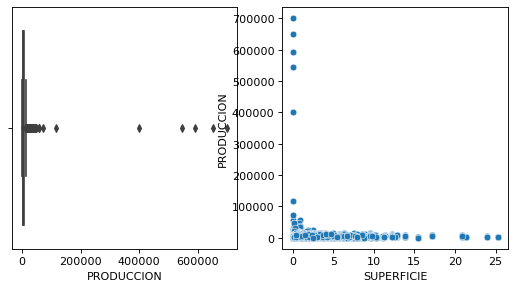

In [ ]:
plt.figure(figsize=(8, 4), dpi=80)

train_varianza = train_bo.copy()
train_varianza["PRODUCCION"] = train_varianza["PRODUCCION"]/train_bo["SUPERFICIE"]
train_varianza = train_varianza[train_varianza["CAMPAÑA"]<22]
plt.subplot(1, 2, 1)
sns.boxplot(train_varianza["PRODUCCION"])
plt.subplot(1, 2, 2)

sns.scatterplot(train_varianza["SUPERFICIE"],train_varianza["PRODUCCION"])

Eliminamos los valores más extremos haciedno un test zscore, y eliminando los valores superiores a 1.9, que correspondería al segundo nivel de la regla 68-95-99.7, es decir al 95%. Muy probablemente estos valores se hayan dado por haber puesto mal la superfície, y por esa razón los eliminamos. 

<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

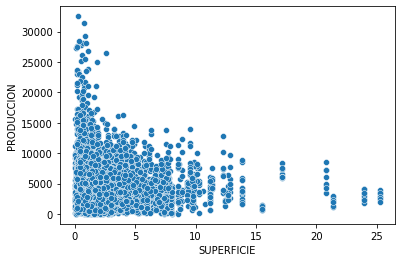

In [ ]:
from scipy import stats
z = np.abs(stats.zscore(train_varianza["PRODUCCION"]))
indices = np.where(z>1.9)[0]
outliers = train_bo.iloc[indices]
train_varianza = train_varianza.drop(index=indices)
train_bo = train_bo.drop(index=indices)

sns.scatterplot(train_varianza["SUPERFICIE"],train_varianza["PRODUCCION"])


Teniendo la producción por hectárea de cada finca, vemos oportuno ver como varia está por estaciones y por campaña, que no podría servir como indicador de si las fincas de una misma estación responden parecido o no según la climatología

In [ ]:
import math
keys = list(train_varianza[["CAMPAÑA","ID_ESTACION"]].columns.values)
def Plot_Varianza_Estacion(train,feature="PRODUCCION"):
    Var_estaciones = [[] for x in range(20)]
    len_valores = [[0] for x in range(20)]
    Camp_Est = train.set_index(keys).index
    Camp_Est = Camp_Est.drop_duplicates()
    for pair in Camp_Est:
        valores = train[(train["CAMPAÑA"]==pair[0])&(train["ID_ESTACION"]==pair[1])][feature]
        if(len(valores)>1):
            Var_estaciones[pair[1]].append(valores.std()*len(valores))
            len_valores[pair[1]].append(len(valores))
        else:
            Var_estaciones[pair[1]].append(0)
            len_valores[pair[1]].append(len(valores))

    medias_diferencia_hectarea = []
    for est,num in zip(Var_estaciones,len_valores):
        medias_diferencia_hectarea.append(np.sum(est)/np.sum(num))
    plt.xticks(range(0,19))
    plt.plot(medias_diferencia_hectarea)
    medias_diferencia_hectarea = [0 if math.isnan(x) else x for x in medias_diferencia_hectarea]    
    valores_campaña = []
    for valores in len_valores:
        valores_campaña.append(np.sum(valores))
    print("Media:",np.sum(np.array(medias_diferencia_hectarea)*np.array(valores_campaña))/np.sum(valores_campaña))


Media: 3016.7134199537118


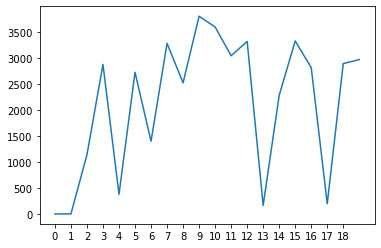

In [ ]:
Plot_Varianza_Estacion(train_varianza)

Vemos que la varianza segun estación varia bastante, y por lo tanto es probable que los factores climatológicos no sean de gran ayuda. 
Aun así, sabemos por el mapa de correlaciones modo tiene impacto considerable en la producción, así que probamos de mirar la varianza discriminando por modo de cultivo


In [ ]:
def dataset_varianza(feature,dataset_or = train_bo):
    unique_feature = dataset_or[feature].drop_duplicates().values
    lista_datasets = []
    for valor in unique_feature:
        dataset = dataset_or[dataset_or[feature]==valor]
        dataset["PRODUCCION"] = dataset["PRODUCCION"]/dataset["SUPERFICIE"]
        dataset = dataset[dataset["CAMPAÑA"]<22]
        lista_datasets.append(dataset)
    return lista_datasets

NameError: ignored

In [ ]:
train_varianza_modo0,train_varianza_modo1 = dataset_varianza("MODO")

Media: 2824.9275005085315


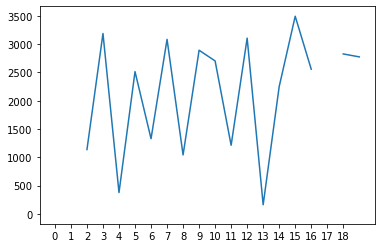

In [ ]:
Plot_Varianza_Estacion(train_varianza_modo0)


Media: 2878.810807519239


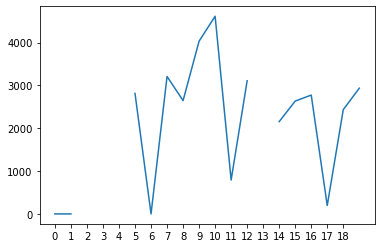

In [ ]:
Plot_Varianza_Estacion(train_varianza_modo1)


Mejora relativamente discriminando por el modo de cultivo, por lo tanto esta diferencia hay que tenerla presente.

Volvemos a mirar posibles outliers de producción respecto superfície. Vemos que hay valores que se salen de la tendencia, tanto negativamente como positivamente



<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

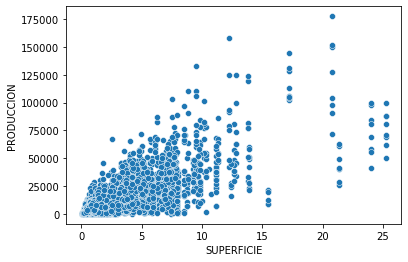

In [ ]:
sns.scatterplot(train_bo["SUPERFICIE"],train_bo["PRODUCCION"])


Intentando precisar, vemos que la mayoría de posibles outliers provienen de una baja producción, y sobretodo en superfícies menores

103
51


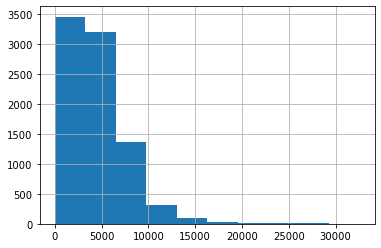

In [ ]:
(train_bo.loc[train_bo.CAMPAÑA<22]["PRODUCCION"]/train_bo.loc[train_bo.CAMPAÑA<22]["SUPERFICIE"]).hist()
print((train_bo.loc[train_bo.CAMPAÑA<22]["PRODUCCION"]/train_bo.loc[train_bo.CAMPAÑA<22]["SUPERFICIE"] <200).sum())
print((train_bo.loc[train_bo.CAMPAÑA<22]["PRODUCCION"]/train_bo.loc[train_bo.CAMPAÑA<22]["SUPERFICIE"] >17000).sum())

84
34


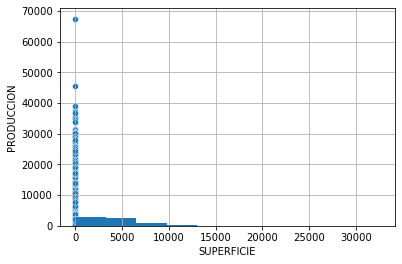

In [ ]:
posibles_outliers = train_bo.loc[train_bo.SUPERFICIE<3]
sns.scatterplot(posibles_outliers["SUPERFICIE"],posibles_outliers["PRODUCCION"])
posibles_outliers["PROD_SUP"] = posibles_outliers["PRODUCCION"]/posibles_outliers["SUPERFICIE"]


Finalmente decidimos eliminar aquellas fincas con una producción menor por superfície de 200. Si bien es cierto que es un valor arbitrario y no conocemos la densidad de vid de cada finca y por lo tanto podrían ser valores reales, es el que ha proporcionado mejores resultados más adelante, y muy probablemente se hayan dado a causas externas que con estos datos no se podrían modelar.

In [ ]:
(posibles_outliers["PRODUCCION"]/posibles_outliers["SUPERFICIE"]).hist()
print((posibles_outliers.loc[train_bo.CAMPAÑA<22]["PRODUCCION"]/posibles_outliers.loc[train_bo.CAMPAÑA<22]["SUPERFICIE"] <200).sum())
print((posibles_outliers.loc[train_bo.CAMPAÑA<22]["PRODUCCION"]/posibles_outliers.loc[train_bo.CAMPAÑA<22]["SUPERFICIE"] >20000).sum())

<AxesSubplot:xlabel='SUPERFICIE', ylabel='PRODUCCION'>

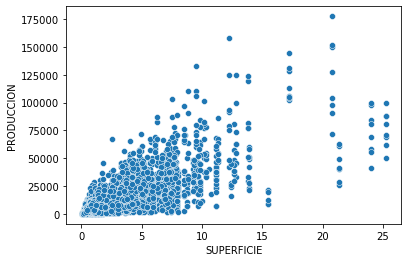

In [ ]:
indices = train_varianza.index[train_varianza["PRODUCCION"]<200]
train_bo = train_bo.drop(index=indices)
sns.scatterplot(train_bo["SUPERFICIE"],train_bo["PRODUCCION"])


### Producción por hectárea esperada por cultivo según finca y variedad


Tratando estos outliers, nos hemos encontrado con el concepto de densidad de vid por superfície. No podemos saberla de ninguna manera, pero si que podemos tratar de calcular una estimación de la producción por hectárea de cada finca (que serviría para explicar la densidad de vid) con los datos de las diferentes campañas.

Nuestro objetivo principal es conseguir una estimación correcta de producción por hectárea para la campaña 22, y por lo tanto de sus fincas. 

Dado que tenemos con total garantía las producciones y superficies de las campañas 20 y 21, lo haremos principalmente a partir de estos resultados si las producciones de ambas son coherentes. 

En algunos casos utilizaremos también valores de anteriores campañas, si vemos que las campañas 21 y 22 son muy diferentes en términos de producción.
Empezaremos mirando por aquellas fincas que tienen la misma superfície en la 20,21 y 22

In [ ]:
train_bo["ESTIMACION"] = 0

In [ ]:
fincas_22 = train_bo[train_bo["CAMPAÑA"]==22]
fincas_21 = train_bo[train_bo["CAMPAÑA"]==21]
fincas_20 = train_bo[train_bo["CAMPAÑA"]==20]

keys = list(train_bo[["ID_FINCA","VARIEDAD","MODO","TIPO","SUPERFICIE"]].columns.values)

i_22 = fincas_22.set_index(keys).index
i_21 = fincas_21.set_index(keys).index
i_20 = fincas_20.set_index(keys).index
#Aquellas fincas que se mantienen igual
fincas_iguales = i_22[i_22.isin(i_21[i_21.isin(i_20)])]
lista_indices = []

for fincas in fincas_iguales:
    finca_20 = fincas_20.loc[(fincas_20.ID_FINCA == fincas[0]) & (fincas_20.VARIEDAD == fincas[1]) & (fincas_20.MODO == fincas[2])
                            &(fincas_20.TIPO==fincas[3]) & (fincas_20.SUPERFICIE == fincas[4])]
    finca_21 = fincas_21.loc[(fincas_21.ID_FINCA == fincas[0]) & (fincas_21.VARIEDAD == fincas[1]) & (fincas_21.MODO == fincas[2])
                            &(fincas_21.TIPO==fincas[3]) & (fincas_21.SUPERFICIE == fincas[4])]
    finca_22 = fincas_22.loc[(fincas_22.ID_FINCA == fincas[0]) & (fincas_22.VARIEDAD == fincas[1]) & (fincas_22.MODO == fincas[2])
                            &(fincas_22.TIPO==fincas[3]) & (fincas_22.SUPERFICIE == fincas[4])]
    #Consideramos que se puede estimar si la diferencia entre producción de las
    #campañas no es muy grande o su producción por hectárea es menor a 3500 (valor 
    #sacado mirando la desviación estándard media entre campaña 20 y 21)
    if((np.abs(finca_20["PRODUCCION"].values-finca_21["PRODUCCION"].values) <5000) | (np.abs(finca_20["PRODUCCION"].values/fincas[4]-finca_21["PRODUCCION"].values/fincas[4])<3500)):
        estimacion = (finca_20["PRODUCCION"].values/fincas[4]+finca_21["PRODUCCION"].values/fincas[4])/2
        train_bo.loc[finca_20.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion
        fincas_20.loc[finca_20.index,"ESTIMACION"] = estimacion
        fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion


De este método conseguimos rellenar más de la mitad de los valores. 

Ahora trabajaremos con aquellas fincas con superfície diferente. Si bien es cierto que se puede tratar del mismo cultivo, y por lo tanto se podría seguir la misma metodología, también se puede tratar de un cultivo completamente diferente. Por lo tanto, disminuiremos un poco los valores de threshold.

In [ ]:
fincas_22= fincas_22.loc[fincas_22.ESTIMACION == 0]
keys = list(train_bo[["ID_FINCA","VARIEDAD","MODO","TIPO"]].columns.values)

i_22 = fincas_22.set_index(keys).index
i_21 = fincas_21.set_index(keys).index
i_20 = fincas_20.set_index(keys).index

fincas_iguales_1 = i_22[i_22.isin(i_21[i_21.isin(i_20)])]
lista_indices = []

for fincas in fincas_iguales_1:
    finca_20 = fincas_20.loc[(fincas_20.ID_FINCA == fincas[0]) & (fincas_20.VARIEDAD == fincas[1]) & (fincas_20.MODO == fincas[2])
                            &(fincas_20.TIPO==fincas[3])]
    finca_21 = fincas_21.loc[(fincas_21.ID_FINCA == fincas[0]) & (fincas_21.VARIEDAD == fincas[1]) & (fincas_21.MODO == fincas[2])
                            &(fincas_21.TIPO==fincas[3])]
    finca_22 = fincas_22.loc[(fincas_22.ID_FINCA == fincas[0]) & (fincas_22.VARIEDAD == fincas[1]) & (fincas_22.MODO == fincas[2])
                            &(fincas_22.TIPO==fincas[3])]
    estimacion = (finca_20["PRODUCCION"].values/finca_20["SUPERFICIE"].values+finca_21["PRODUCCION"].values/finca_21["SUPERFICIE"].values)/2
    if((np.abs(finca_20["PRODUCCION"].values-finca_21["PRODUCCION"].values) <4000) | (np.abs(finca_20["PRODUCCION"].values/finca_20["SUPERFICIE"].values-finca_21["PRODUCCION"].values/finca_21["SUPERFICIE"].values)<2000)):
        train_bo.loc[finca_20.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion
        fincas_20.loc[finca_20.index,"ESTIMACION"] = estimacion
        fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion


Quedan 330 fincas por estimar, procederemos con aquellas que solo aparecen en la campaña 22 y la 21, sin darle importancia a la superfície en este caso, puesto que no es una garantía de nada. Añadir el valor de estimación pasado nos debería disminuir el error final, ya que la media es el mejor estimador de la esperanza (que es realmente lo que estamos calculando, una esperanza de la estimación de producción)

In [ ]:
fincas_22= fincas_22.loc[fincas_22.ESTIMACION == 0]
fincas_antes = train_bo[train_bo["CAMPAÑA"]<21]
keys = list(train_bo[["ID_FINCA","VARIEDAD","MODO","TIPO"]].columns.values)

i_22 = fincas_22.set_index(keys).index
i_21 = fincas_21.set_index(keys).index
i_antes = fincas_antes.set_index(keys).index

i_22 = i_22[~i_22.isin(i_antes)]
fincas_iguales_2 = i_22[i_22.isin(i_21)]
lista_indices = []
for fincas in fincas_iguales_2:
    finca_21 = fincas_21.loc[(fincas_21.ID_FINCA == fincas[0]) & (fincas_21.VARIEDAD == fincas[1]) & (fincas_21.MODO == fincas[2])
                            &(fincas_21.TIPO==fincas[3])]
    finca_22 = fincas_22.loc[(fincas_22.ID_FINCA == fincas[0]) & (fincas_22.VARIEDAD == fincas[1]) & (fincas_22.MODO == fincas[2])
                            &(fincas_22.TIPO==fincas[3])]

    estimacion = finca_21["PRODUCCION"].values/finca_21["SUPERFICIE"].values
    
    train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
    train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion
    fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
    fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion


Hemos reducido en 50 los valores a rellenar. Provemos de rellenar ahora con valores que aparezcan en cualquier año, es decir teniendo en cuenta las otras campañas aprovechando que hemos llenado también sus valores de superfície.

In [ ]:
fincas_22= fincas_22.loc[fincas_22.ESTIMACION == 0]
fincas_todas = train_bo[train_bo["CAMPAÑA"]<22]
keys = list(train_bo[["ID_FINCA","VARIEDAD","MODO","TIPO"]].columns.values)

i_22 = fincas_22.set_index(keys).index
i_todas = fincas_todas.set_index(keys).index

fincas_iguales_todas = i_22[i_22.isin(i_todas)]

for finca in fincas_iguales_todas:
    fincas = fincas_todas.loc[(fincas_todas.ID_FINCA == finca[0]) & (fincas_todas.VARIEDAD == finca[1]) & (fincas_todas.MODO == finca[2])
                            &(fincas_todas.TIPO==finca[3])]
    finca_22 = fincas_22.loc[(fincas_22.ID_FINCA == finca[0]) & (fincas_22.VARIEDAD == finca[1]) & (fincas_22.MODO == finca[2])
                            &(fincas_22.TIPO==finca[3])]

    estimacion = np.mean(fincas["PRODUCCION"]/fincas["SUPERFICIE"])
    
    train_bo.loc[fincas.index,"ESTIMACION"] = estimacion
    train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion
    fincas_todas.loc[fincas.index,"ESTIMACION"] = estimacion
    fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion



Observando el dataset, hemos visto algunos casos que el cambio se produce en el modo de cultivo. Vamos a tratar de hallar estas variaciones, y hacer la estimación acorde al cambio de modo (recordemos que se obtiene mayor producción con el modo 1!)

In [ ]:
fincas_22= fincas_22.loc[fincas_22.ESTIMACION == 0]
keys = list(train_bo[["ID_FINCA","VARIEDAD","TIPO"]].columns.values)

i_22 = fincas_22.set_index(keys).index
i_21 = fincas_21.set_index(keys).index
i_20 = fincas_20.set_index(keys).index

fincas_iguales_3 = i_22[i_22.isin(i_21)]
fincas_iguales_4 = i_22[i_22.isin(i_20)]

lista_indices = []
#Tendremos que mirar que el modo para todas sean diferentes, porque sino se tratará de un caso que antes hemos descartado de llenar
conjunto_20_21 = fincas_21.append(fincas_20)
medias_modo0 = np.mean(conjunto_20_21.loc[conjunto_20_21.MODO==0]["PRODUCCION"]/conjunto_20_21.loc[conjunto_20_21.MODO==0]["SUPERFICIE"])
medias_modo1 = np.mean(conjunto_20_21.loc[conjunto_20_21.MODO==1]["PRODUCCION"]/conjunto_20_21.loc[conjunto_20_21.MODO==1]["SUPERFICIE"])
# se espera una producción 50% mayor si es con modo 1 medias_modo1/medias_modo0

#Primero llenaremos aquellas que estan solo en la campaña 20 o 21, y luego las que estan en ambas (solo hay un caso en la campaña 21)
fincas_modo_21 = fincas_iguales_3[~fincas_iguales_3.isin(fincas_iguales_4)]
for fincas in fincas_modo_21:
    finca_21 = fincas_21.loc[(fincas_21.ID_FINCA == fincas[0]) & (fincas_21.VARIEDAD == fincas[1]) 
                            &(fincas_21.TIPO==fincas[2])]
    finca_22 = fincas_22.loc[(fincas_22.ID_FINCA == fincas[0]) & (fincas_22.VARIEDAD == fincas[1]) 
                            &(fincas_22.TIPO==fincas[2])]
    if (finca_21["MODO"].values[0] != finca_22["MODO"].values):
        estimacion = finca_21["PRODUCCION"].values[0]/finca_21["SUPERFICIE"].values[0]
        train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion*finca_21["MODO"].values[0]/1.5 + estimacion*finca_22["MODO"].values*1.5 
        fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion
    elif (len(finca_21["MODO"].values)>1):
        estimacion = finca_21["PRODUCCION"].values[1]/finca_21["SUPERFICIE"].values[1]
        train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5
        fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion
    
#Ahora aquellas que aparecen en las campañas 20,21 y 22    
fincas_iguales = i_22[i_22.isin(i_21[i_21.isin(i_20)])]
for fincas in fincas_iguales:
    finca_20 = fincas_20.loc[(fincas_20.ID_FINCA == fincas[0]) & (fincas_20.VARIEDAD == fincas[1]) 
                            &(fincas_20.TIPO==fincas[2])]
    finca_21 = fincas_21.loc[(fincas_21.ID_FINCA == fincas[0]) & (fincas_21.VARIEDAD == fincas[1]) 
                            &(fincas_21.TIPO==fincas[2])]
    finca_22 = fincas_22.loc[(fincas_22.ID_FINCA == fincas[0]) & (fincas_22.VARIEDAD == fincas[1]) 
                            &(fincas_22.TIPO==fincas[2])]
    
    finca_20 = finca_20.loc[finca_20.MODO.values != finca_22.MODO.values]
    finca_21 = finca_21.loc[finca_21.MODO.values != finca_22.MODO.values]

    modo_22 = finca_22["MODO"].values
    #comprovamos si hay algun modo diferente
    if (len(finca_20)==1 and len(finca_21)==1):
        estimacion = (finca_20["PRODUCCION"].values/finca_20["SUPERFICIE"].values+finca_21["PRODUCCION"].values/finca_21["SUPERFICIE"].values)/2
        train_bo.loc[finca_20.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5 *(1-modo_22) + estimacion*1.5*modo_22
        fincas_20.loc[finca_20.index,"ESTIMACION"] = estimacion
        fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5 *(1-modo_22) + estimacion*1.5*modo_22
    elif(len(finca_20)==1):
        estimacion = finca_20["PRODUCCION"].values/finca_20["SUPERFICIE"].values
        train_bo.loc[finca_20.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5 *(1-modo_22) + estimacion*1.5*modo_22
        fincas_20.loc[finca_20.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5 *(1-modo_22) + estimacion*1.5*modo_22
    elif(len(finca_21)==1):
        estimacion = finca_21["PRODUCCION"].values/finca_21["SUPERFICIE"].values
        train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
        train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5 *(1-modo_22) + estimacion*1.5*modo_22
        fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion
        fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion/1.5 *(1-modo_22) + estimacion*1.5*modo_22


Los valores que quedan por rellenar no tienen una finca correspondiente. Por lo tanto tendremos en cuenta la variedad y el modo de cultivo respecto las campañas 20 y 21.

In [ ]:
fincas_22= fincas_22.loc[fincas_22.ESTIMACION == 0]
keys = list(train_bo[["VARIEDAD","MODO"]].columns.values)
i_22 = fincas_22.set_index(keys).index.drop_duplicates()
for comb in i_22:
    fincas = conjunto_20_21.loc[(conjunto_20_21.VARIEDAD == comb[0]) & (conjunto_20_21.MODO == comb[1])]
    finca_22 = fincas_22.loc[(fincas_22.VARIEDAD == comb[0]) & (fincas_22.MODO == comb[1])]

    estimacion = np.mean(fincas["PRODUCCION"]/fincas["SUPERFICIE"])
    train_bo.loc[finca_22.index,"ESTIMACION"] = estimacion
    fincas_22.loc[finca_22.index,"ESTIMACION"] = estimacion

Hemos llenado ya todas las estimaciones para la campaña 22. Para poder evaluar este método, que principalmente lo haremos con la campaña 21, debemos llenar la estimación para todas las otras campañas. Vamos a rellenar haciendo la media de los valores de producción de la finca. Aquellas que solo aparezcan una vez serán eliminadas, ya que realmente no nos aportan ninguna información útil (excepto de la campaña 21, que llenaremos según la producción media de su variedad y el modo de cultivo).

In [ ]:
train_finca = train_bo[train_bo["CAMPAÑA"]<22]
keys = list(train_finca[["VARIEDAD","ID_FINCA","TIPO","MODO"]].columns.values)

fincas = train_finca.set_index(keys).index.drop_duplicates()

for com in fincas:
    estimacion = np.mean(train_finca.loc[(train_finca["VARIEDAD"]==com[0]) & (train_finca["ID_FINCA"]==com[1]) & (train_finca["TIPO"]==com[2]),"PRODUCCION"]/train_finca.loc[(train_finca["VARIEDAD"]==com[0]) & (train_finca["ID_FINCA"]==com[1]) & (train_finca["TIPO"]==com[2]),"SUPERFICIE"])
    if (len(train_finca.loc[(train_finca["VARIEDAD"]==com[0]) & (train_finca["ID_FINCA"]==com[1]) & (train_finca["TIPO"]==com[2])])>1):
        train_finca.loc[(train_finca["VARIEDAD"]==com[0]) & (train_finca["ID_FINCA"]==com[1]) & (train_finca["TIPO"]==com[2]) & (train_finca["ESTIMACION"]==0),"ESTIMACION"] = estimacion
        train_bo.loc[(train_bo["VARIEDAD"]==com[0]) & (train_bo["ID_FINCA"]==com[1]) & (train_bo["TIPO"]==com[2]) & (train_bo["ESTIMACION"]==0),"ESTIMACION"] = estimacion

In [ ]:
fincas_21= train_finca.loc[(train_finca.ESTIMACION == 0 ) &  (train_finca.CAMPAÑA ==21)]
keys = list(train_bo[["VARIEDAD","MODO"]].columns.values)
i_21 = fincas_21.set_index(keys).index.drop_duplicates()
for comb in i_22:
    fincas = train_finca.loc[(train_finca.VARIEDAD == comb[0]) & (train_finca.MODO == comb[1])]
    finca_21 = fincas_21.loc[(fincas_21.VARIEDAD == comb[0]) & (fincas_21.MODO == comb[1])]
    estimacion = np.mean(fincas["PRODUCCION"]/fincas["SUPERFICIE"])
    train_bo.loc[finca_21.index,"ESTIMACION"] = estimacion
    fincas_21.loc[finca_21.index,"ESTIMACION"] = estimacion

Eliminamos los demás valores

In [ ]:
train_bo = train_bo.loc[train_bo.ESTIMACION !=0]

Aprovechamos para mirar la producción media segun variedad. Esto nos puede servir para comprobar más adelante si nuestra predicción es correcta, si se mantienen las proporciones

In [ ]:
train_finca = train_bo[train_bo["CAMPAÑA"]<22]

4873.149014639198

In [ ]:
train_produccion_esperada = train_finca.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ALTITUD","COLOR","MODO","TIPO"],axis=1)
keys = list(train_produccion_esperada[["VARIEDAD"]].columns.values)
combinaciones = train_produccion_esperada.set_index(keys).index
combinaciones.value_counts()

59    2441
17    1911
32     812
52     535
81     483
68     443
87     352
40     327
15     202
9      189
26     113
94      63
92      54
23      50
43      48
84      47
4       38
65      34
8       30
55      16
62      16
71      14
38       6
10       4
48       3
Name: VARIEDAD, dtype: int64

<AxesSubplot:>

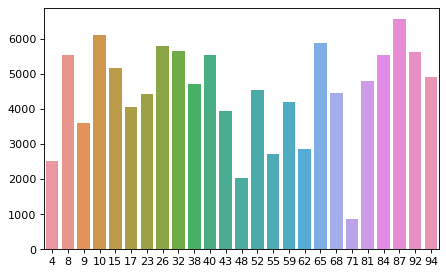

In [ ]:
medias_produccion = []
varianza_produccion = []
numero_fincas = []
orden = []
for i in combinaciones.drop_duplicates():
    orden.append(i)
    medias_produccion.append(np.mean(train_produccion_esperada[train_produccion_esperada["VARIEDAD"]==i]["ESTIMACION"]))
    numero_fincas.append((train_produccion_esperada[train_produccion_esperada["VARIEDAD"]==i]["ESTIMACION"]).size)
plt.figure(figsize=(14, 4), dpi=80)
plt.subplot(1, 2, 1)
sns.barplot(x=combinaciones.drop_duplicates().values, y=medias_produccion)


Aprovechando que hemos creado una variable que nos sirve para hacer una estimación de la producción, podemos mirar como esta estimación varia respecto la realidad

In [ ]:
train_bo["ESTIMACION_PRODUCCION"] = train_bo["ESTIMACION"]*train_bo["SUPERFICIE"]
train_bo["FACTOR_PRODUCCION"] = train_bo["PRODUCCION"]/train_bo["ESTIMACION_PRODUCCION"]
cambio_signo = -1/train_bo[train_bo["FACTOR_PRODUCCION"]<1]["FACTOR_PRODUCCION"]
train_bo.loc[train_bo.FACTOR_PRODUCCION<1,"FACTOR_PRODUCCION"] = cambio_signo+1
train_bo.loc[train_bo.FACTOR_PRODUCCION>0,"FACTOR_PRODUCCION"] = train_bo.loc[train_bo.FACTOR_PRODUCCION>0,"FACTOR_PRODUCCION"]-1

Numero de casos donde la estimación es menor a la producción: 3904
Numero de casos donde la estimación es menor a la producción: 4272


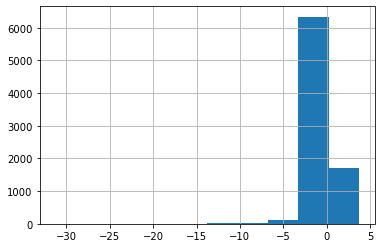

In [ ]:
train_bo["FACTOR_PRODUCCION"].hist()
print(f'Numero de casos donde la estimación es menor a la producción: {(train_bo["FACTOR_PRODUCCION"]>0).sum()}')
print(f'Numero de casos donde la estimación es menor a la producción: {(train_bo["FACTOR_PRODUCCION"]<0).sum()}')

En general los valores estan alrededor de 0, con una tendencia a sobreestimar quiza, pero si que podemos observar outliers en los valores negativos, seguramente debidos a algún problema en el viñedo esa campaña. Quitamos los valores donde FACTOR_PRODUCCION muestra una desviación muy amplia, puesto que son valores que añadiran solo error.

In [ ]:
index_outliers = train_bo.index[np.abs(train_bo["FACTOR_PRODUCCION"])>5]
train_bo = train_bo[~train_bo.index.isin(index_outliers)]

<AxesSubplot:>

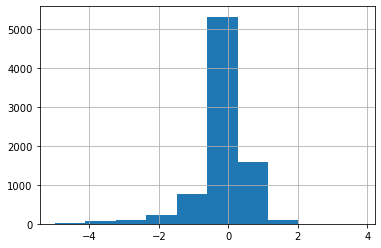

In [ ]:
train_bo["FACTOR_PRODUCCION"].hist()


Habiendo obtenido la producción media esperada por hectárea, y la diferencia entre nuestra produccion estimada y la real, podemos recuperar el trabajo de la varianza respecto las estaciones (clima), y ver si el factor es parecido en la misma estación en la misma campaña o no.

Media: 0.6671330513151834


12    1971
5     1106
7     1069
16    1060
15     927
19     911
18     747
14     573
10     234
3      229
9      179
8       87
6       46
2       45
13      16
11      15
17       6
1        2
Name: ID_ESTACION, dtype: int64

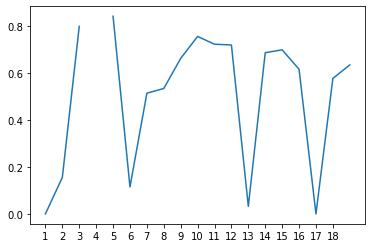

In [ ]:
train_varianza = train_bo[train_bo["CAMPAÑA"]<22]
keys = list(train_varianza[["CAMPAÑA","ID_ESTACION"]].columns.values)
Plot_Varianza_Estacion(train_varianza,"FACTOR_PRODUCCION")
train_bo["ID_ESTACION"].value_counts()

Observamos que donde hay mayor varianza en el incremento o decremento de producción respecto la estación meteorológica es en aquellas estaciones con mayor número de entradas en el dataset, es decir con más fincas. Eso puede significar que son estaciones que abarcan una área mayor y por lo tanto la información de la estación respecto a la realidad de la finca varia más.

Para finalizar está parte de EDA (que nos ha llevado a hacer feature engineering), podemos mirar el error de nuestras campañas respecto a la producción utilizando nuestra estimación.

<AxesSubplot:>

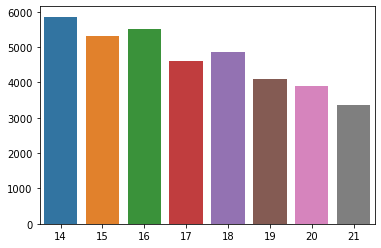

In [ ]:
test = train_bo[train_bo["CAMPAÑA"]<22]
RMSE_campaña = []
for camp in [14,15,16,17,18,19,20,21]:
    data = train_bo[train_bo.CAMPAÑA==camp]
    RMSE_campaña.append(np.sqrt(np.mean((data["ESTIMACION_PRODUCCION"] - data["PRODUCCION"])**2)))

sns.barplot(x=[14,15,16,17,18,19,20,21], y=RMSE_campaña)


Para las campañas 21 y 20 evidentemente se consiguen los valores más bajos de RMSE, ya que se ha usado de manera muy explícita sus valores de producción. Lo que es interesante es que los valores más bajos de RMSE son las campañas más próximas y dos de las tres peores no se utilizaran para la predicción ya que no disponemos datos meteorológicos veraces (14 y 15).
Teniendo en cuenta esto, quitaremos del train estos valores, y miraremos finalmente como está el valor de factor producción teniendo en cuenta el modo de cultivo

In [ ]:
#quitamos ya las campañas 14 y 15
train_bo= train_bo.loc[(train_bo.CAMPAÑA != 14) & (train_bo.CAMPAÑA !=15)]
test = train_bo[train_bo["CAMPAÑA"]<22]
print("Diferencia Produccion Modo 1:",np.mean(test.loc[test.MODO==1]["ESTIMACION_PRODUCCION"] - test.loc[test.MODO==1]["PRODUCCION"]))
print("Diferencia Produccion Modo 0:",np.mean(test.loc[test.MODO==0]["ESTIMACION_PRODUCCION"] - test.loc[test.MODO==0]["PRODUCCION"]))


Diferencia Produccion Modo 1: -12.744395626888926
Diferencia Produccion Modo 0: 131.2856558393863


Parece ser que hay un cierto bias sobretodo en el Modo 0 a sobreestimar, pero no debería ser un gran problema, puesto que no es muy notorio.

#### ETO DATASET

Procedemos a tratar el dataset ETO (teniendo en cuenta METEO también)

In [ ]:
ETO_dataset.head()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,20150629,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13
1,20150630,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,2.2,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13
2,20150701,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,2.7,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13
3,20150702,288.9,289.4,287.9,288.3,291.8,286.1,287.7,289.4,286.1,...,1.7,2.3,1.2,3.6,5.4,2.4,2.7,3.4,2.4,13
4,20150703,289.1,290.4,288.5,290.5,293.0,287.8,290.6,293.0,288.5,...,3.5,5.0,2.3,3.1,6.0,1.5,1.9,2.2,1.5,13


In [ ]:
ETO_dataset.isnull().sum()

date                          0
DewpointLocalAfternoonAvg     0
DewpointLocalAfternoonMax     0
DewpointLocalAfternoonMin     0
DewpointLocalDayAvg           0
                             ..
WindSpeedLocalNighttimeMin    0
WindSpeedLocalOvernightAvg    0
WindSpeedLocalOvernightMax    0
WindSpeedLocalOvernightMin    0
ID_ESTACION                   0
Length: 275, dtype: int64

Lo primero que vemos es que las fechas de los datasets METEO y ETO tienen formato distinto. Para poder trabajar mejor, vamos a cambiar primero el formato de ETO.

In [ ]:
ETO_dataset['date'] = pd.to_datetime(ETO_dataset['date'], format="%Y%m%d")
ETO_dataset.head()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,2015-06-29,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13
1,2015-06-30,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,2.2,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13
2,2015-07-01,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,2.7,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13
3,2015-07-02,288.9,289.4,287.9,288.3,291.8,286.1,287.7,289.4,286.1,...,1.7,2.3,1.2,3.6,5.4,2.4,2.7,3.4,2.4,13
4,2015-07-03,289.1,290.4,288.5,290.5,293.0,287.8,290.6,293.0,288.5,...,3.5,5.0,2.3,3.1,6.0,1.5,1.9,2.2,1.5,13


El dataset ETO contiene muchas variables que explican diferentes periodos del dia. Como nosotros queremos agrupar los datasets por dias vamos a eliminar las variables que no expliquen un dia entero, és decir, las siguientes variables:

In [ ]:
for i,j in enumerate(ETO_dataset.keys()):
    if j == "date" :
        continue
    elif j == 'ID_ESTACION':
        continue
    elif "Day" not in j:
        ETO_dataset.drop(j, axis=1, inplace=True)
    elif "Daytime" in j:
        ETO_dataset.drop(j, axis=1, inplace=True)
ETO_dataset.head()

,date,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,EvapotranspirationLocalDayAvg,EvapotranspirationLocalDayMax,EvapotranspirationLocalDayMin,FeelsLikeLocalDayAvg,FeelsLikeLocalDayMax,FeelsLikeLocalDayMin,...,UVIndexLocalDayAvg,UVIndexLocalDayMax,UVIndexLocalDayMin,VisibilityLocalDayAvg,VisibilityLocalDayMax,VisibilityLocalDayMin,WindSpeedLocalDayAvg,WindSpeedLocalDayMax,WindSpeedLocalDayMin,ID_ESTACION
0,2015-06-29,286.0,287.0,285.4,NaN,NaN,NaN,304.1,307.6,298.6,...,0.5,2,0,16093.0,16093,16093,4.0,5.2,2.3,13
1,2015-06-30,284.3,286.5,282.5,NaN,NaN,NaN,299.2,309.0,289.6,...,2.5,9,0,16093.0,16093,16093,3.3,5.9,1.1,13
2,2015-07-01,285.8,288.0,283.8,NaN,NaN,NaN,298.3,305.9,290.8,...,2.7,10,0,16093.0,16093,16093,3.6,6.5,1.2,13
3,2015-07-02,288.3,291.8,286.1,NaN,NaN,NaN,297.6,303.8,293.2,...,2.3,8,0,16093.0,16093,16093,3.0,5.4,1.2,13
4,2015-07-03,290.5,293.0,287.8,NaN,NaN,NaN,298.2,305.1,292.6,...,2.6,10,0,16093.0,16093,16093,4.2,6.5,2.3,13


A continuación, eliminaremos aquellas que no afectan al desarollo de la viña.

In [ ]:
ETO_dataset=ETO_dataset.drop('FeelsLikeLocalDayAvg', axis=1)
ETO_dataset=ETO_dataset.drop('FeelsLikeLocalDayMax', axis=1)
ETO_dataset=ETO_dataset.drop('FeelsLikeLocalDayMin', axis=1)

Añadimos el año, la semana y el mes de cada valor, ya que más adelante nos pueden ser muy útiles (y el año hará faltar para unir con train)

In [ ]:
ETO_dataset['Week'] = ETO_dataset['date'].dt.week
ETO_dataset['Month'] = ETO_dataset['date'].dt.month
ETO_dataset['Year'] = ETO_dataset['date'].dt.year

Vemos que hay algunos valores que son NaN. Probaremos de llenarlos con modelos (solo los Avg, los demás los eliminamos).

In [ ]:
ETO_dataset.isnull().sum()

date                                         0
DewpointLocalDayAvg                          0
DewpointLocalDayMax                          0
DewpointLocalDayMin                          0
EvapotranspirationLocalDayAvg            34580
EvapotranspirationLocalDayMax            34580
EvapotranspirationLocalDayMin            34580
GlobalHorizontalIrradianceLocalDayAvg    34580
GlobalHorizontalIrradianceLocalDayMax    34580
GlobalHorizontalIrradianceLocalDayMin    34580
GustLocalDayAvg                          36765
GustLocalDayMax                          36765
GustLocalDayMin                          36765
MSLPLocalDayAvg                          14980
MSLPLocalDayMax                          14980
MSLPLocalDayMin                          14980
PrecipAmountLocalDayAvg                      0
PrecipAmountLocalDayMax                      0
PrecipAmountLocalDayMin                      0
RelativeHumidityLocalDayAvg                  0
RelativeHumidityLocalDayMax                  0
RelativeHumid

Miramos también como son sus distribuciones, para luego compararles después de hacer la imputación con modelos.

In [ ]:
ETO_dataset = ETO_dataset.drop(["EvapotranspirationLocalDayMax","EvapotranspirationLocalDayMin","EvapotranspirationLocalDayMin","EvapotranspirationLocalDayMax",
                "GlobalHorizontalIrradianceLocalDayMax","GlobalHorizontalIrradianceLocalDayMin","MSLPLocalDayMax","MSLPLocalDayMin","GustLocalDayMax","GustLocalDayMin"],axis=1)

<AxesSubplot:>

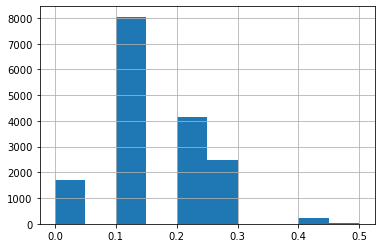

In [ ]:
ETO_dataset["EvapotranspirationLocalDayAvg"].hist()


<AxesSubplot:>

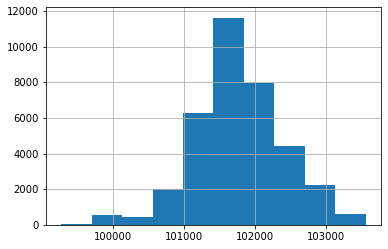

In [ ]:
ETO_dataset["MSLPLocalDayAvg"].hist()


<AxesSubplot:>

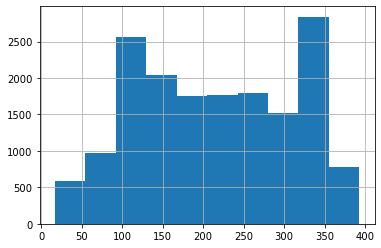

In [ ]:
ETO_dataset["GlobalHorizontalIrradianceLocalDayAvg"].hist()


<AxesSubplot:>

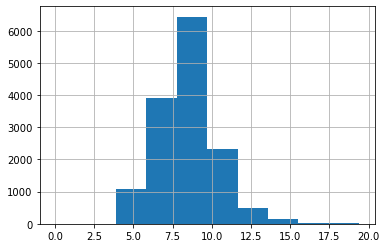

In [ ]:
ETO_dataset["GustLocalDayAvg"].hist()

Empezamos prediciendo la Evatransporación, ya que solo tiene 6 valores diferentes y lo podemos tratar como un problema de clasificación, que en principio debería acumular menos errores que una regresión.

In [ ]:
Evatransporation = ETO_dataset.drop(["MSLPLocalDayAvg","GustLocalDayAvg","GlobalHorizontalIrradianceLocalDayAvg","date","ID_ESTACION"],axis=1)
X = Evatransporation[~Evatransporation.isnull().any(axis=1)]
target_y = X["EvapotranspirationLocalDayAvg"]
Pred_X = Evatransporation[Evatransporation.isnull().any(axis=1)].drop("EvapotranspirationLocalDayAvg",axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel


X_train, X_test, y_train, y_test = train_test_split(X.drop(["EvapotranspirationLocalDayAvg"],axis=1), (target_y*10).astype(int)
, test_size=0.3, random_state=99)
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
regr = RandomForestClassifier(n_estimators = 1000,max_depth=25, random_state=0,n_jobs=-1)
regr.fit(X_train,y_train)

prediccio = regr.predict(X_test)
print(f'Accuracy score: {balanced_accuracy_score(y_test,prediccio)}')

confusion_matrix(y_test, prediccio)


Accuracy score: 0.9526597737292991


array([[ 488,   37,    0,    0,    0,    0],
       [  12, 2408,   30,    0,    0,    0],
       [   0,   24, 1164,   35,    0,    0],
       [   0,    0,   24,  694,    0,    0],
       [   0,    0,    0,    7,   54,    0],
       [   0,    0,    0,    0,    0,    3]], dtype=int64)

Las métricas y el scatterplot nos hacen ver que es un buen modelo para predecir. Por lo tanto lo usaremos para rellenar los valores de la evatransporación

In [ ]:
X_pred = model.transform(Pred_X)
EV_pred =regr.predict(X_pred)
Pred_X["EvapotranspirationLocalDayAvg"] = EV_pred/10
ETO_dataset.loc[ETO_dataset.index.isin(Pred_X["EvapotranspirationLocalDayAvg"].index),"EvapotranspirationLocalDayAvg"] = Pred_X["EvapotranspirationLocalDayAvg"]
ETO_dataset["EvapotranspirationLocalDayAvg"].isnull().sum()

0

In [ ]:
#X.drop("EvapotranspirationLocalDayAvg",axis=1).columns.values[model.get_support()] Podemos saber las features usadas!

<AxesSubplot:>

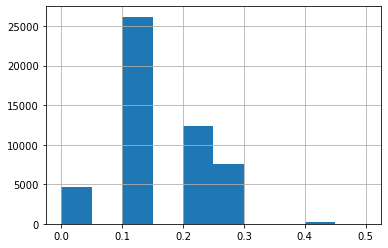

In [ ]:
ETO_dataset["EvapotranspirationLocalDayAvg"].hist() #comparar amb el primer fet

Vamos a seguir la misma meteodología para las demás variables, aunque en vez de usar un clasificador usaremos regresión. Primero trabajaremos MSLP, que es el valor con menos NaN

In [ ]:
Presion = ETO_dataset.drop(["GustLocalDayAvg","GlobalHorizontalIrradianceLocalDayAvg","date","ID_ESTACION","Week","Year"],axis=1)
X = Presion[~Presion.isnull().any(axis=1)]
target_y = X["MSLPLocalDayAvg"]
Pred_X = Presion[Presion.isnull().any(axis=1)].drop("MSLPLocalDayAvg",axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X.drop("MSLPLocalDayAvg",axis=1), target_y
, test_size=0.3, random_state=99,shuffle=True)
lasso = Lasso(alpha=0.3,fit_intercept=False).fit(X_train,y_train)
model = SelectFromModel(lasso, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
regr = RandomForestRegressor(n_estimators = 200,max_depth=25, random_state=0,n_jobs=-1)
regr.fit(X_train,y_train)

prediccio = regr.predict(X_test)
print(f'R2 Score: {r2_score(y_test,prediccio)}')
print(f'MSE: {mean_squared_error(y_test,prediccio,squared=False)}')



R2 Score: 0.9147825226843621
MSE: 181.6747931216325


In [ ]:
#X.drop("MSLPLocalDayAvg",axis=1).columns.values[model.get_support()] Podemos saber las features usadas!

In [ ]:
X_pred = model.transform(Pred_X)
Pres_pred =regr.predict(X_pred)
Pred_X["MSLPLocalDayAvg"] = Pres_pred
ETO_dataset.loc[ETO_dataset.index.isin(Pred_X["MSLPLocalDayAvg"].index),"MSLPLocalDayAvg"] = Pred_X["MSLPLocalDayAvg"]
ETO_dataset["MSLPLocalDayAvg"].isnull().sum()

0

Procedemos con la radiación solar siguiendo el mismo método

In [ ]:
Radiacion = ETO_dataset.drop(["GustLocalDayAvg","date","ID_ESTACION","Year"],axis=1)
X = Radiacion[~Radiacion.isnull().any(axis=1)]
target_y = X["GlobalHorizontalIrradianceLocalDayAvg"]
Pred_X = Radiacion[Radiacion.isnull().any(axis=1)].drop("GlobalHorizontalIrradianceLocalDayAvg",axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.drop("GlobalHorizontalIrradianceLocalDayAvg",axis=1), target_y
, test_size=0.3, random_state=99,shuffle=True)
lasso = Lasso(alpha=0.3,fit_intercept=False).fit(X_train,y_train)
model = SelectFromModel(lasso, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
regr = RandomForestRegressor(n_estimators = 200,max_depth=30, random_state=0,n_jobs=-1)
regr.fit(X_train,y_train)

prediccio = regr.predict(X_test)
print(f'R2 Score: {r2_score(y_test,prediccio)}')
print(f'MSE: {mean_squared_error(y_test,prediccio,squared=False)}')


R2 Score: 0.9935451161932797
MSE: 7.667508307171399


In [ ]:
X_pred = model.transform(Pred_X)
Rad_pred =regr.predict(X_pred)
Pred_X["GlobalHorizontalIrradianceLocalDayAvg"] = Rad_pred
ETO_dataset.loc[ETO_dataset.index.isin(Pred_X["GlobalHorizontalIrradianceLocalDayAvg"].index),"GlobalHorizontalIrradianceLocalDayAvg"] = Pred_X["GlobalHorizontalIrradianceLocalDayAvg"]
ETO_dataset["GlobalHorizontalIrradianceLocalDayAvg"].isnull().sum()

0

In [ ]:
#X.drop("GlobalHorizontalIrradianceLocalDayAvg",axis=1).columns.values[model.get_support()] Podemos saber las features usadas!

<AxesSubplot:>

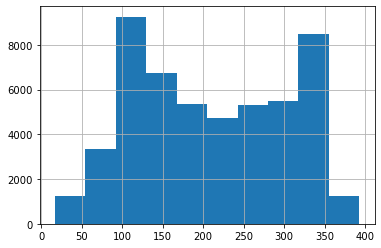

In [ ]:
ETO_dataset["GlobalHorizontalIrradianceLocalDayAvg"].hist()

Finalmente trajamos con gust, las rachas de viento

In [ ]:
Gust = ETO_dataset.drop(["Week","date","ID_ESTACION","Year"],axis=1)
X = Gust[~Gust.isnull().any(axis=1)]
target_y = X["GustLocalDayAvg"]
Pred_X = Gust[Gust.isnull().any(axis=1)].drop("GustLocalDayAvg",axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.drop("GustLocalDayAvg",axis=1), target_y
, test_size=0.3, random_state=99,shuffle=True)
lasso = Lasso(alpha=0.3,fit_intercept=False).fit(X_train,y_train)
model = SelectFromModel(lasso, prefit=True)
X_train = model.transform(X_train)
X_test = model.transform(X_test)
regr = RandomForestRegressor(n_estimators = 200,max_depth=30, random_state=0,n_jobs=-1)
regr.fit(X_train,y_train)

prediccio = regr.predict(X_test)
print(f'R2 Score: {r2_score(y_test,prediccio)}')
print(f'MSE: {mean_squared_error(y_test,prediccio,squared=False)}')


R2 Score: 0.9515413660960207
MSE: 0.3978629150846061


In [ ]:
X_pred = model.transform(Pred_X)
Gust_pred =regr.predict(X_pred)
Pred_X["GustLocalDayAvg"] = Gust_pred
ETO_dataset.loc[ETO_dataset.index.isin(Pred_X["GustLocalDayAvg"].index),"GustLocalDayAvg"] = Pred_X["GustLocalDayAvg"]
ETO_dataset["GustLocalDayAvg"].isnull().sum()

0

In [ ]:
#X.drop("GustLocalDayAvg",axis=1).columns.values[model.get_support()] Podemos saber las features usadas!

<AxesSubplot:>

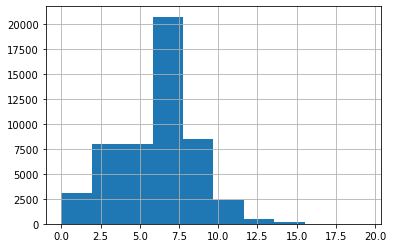

In [ ]:
ETO_dataset["GustLocalDayAvg"].hist()

Hemos conseguido llenar todos los valores

In [ ]:
ETO_dataset.isnull().sum()

date                                     0
DewpointLocalDayAvg                      0
DewpointLocalDayMax                      0
DewpointLocalDayMin                      0
EvapotranspirationLocalDayAvg            0
GlobalHorizontalIrradianceLocalDayAvg    0
GustLocalDayAvg                          0
MSLPLocalDayAvg                          0
PrecipAmountLocalDayAvg                  0
PrecipAmountLocalDayMax                  0
PrecipAmountLocalDayMin                  0
RelativeHumidityLocalDayAvg              0
RelativeHumidityLocalDayMax              0
RelativeHumidityLocalDayMin              0
SnowAmountLocalDayAvg                    0
SnowAmountLocalDayMax                    0
SnowAmountLocalDayMin                    0
TemperatureLocalDayAvg                   0
TemperatureLocalDayMax                   0
TemperatureLocalDayMin                   0
UVIndexLocalDayAvg                       0
UVIndexLocalDayMax                       0
UVIndexLocalDayMin                       0
VisibilityL

In [ ]:
ETO_dataset.drop(["PrecipAmountLocalDayMin","SnowAmountLocalDayMin"], axis=1, inplace=True)
#Ni mínimo de lluvia diaria ni de nieve aporta nada, ya que sera 0 en la mayoría de casos


### METEO

Procedemos a analizar METEO (se hizo de manera paralela con ETO)

In [ ]:
def separate_by_space(string: str, index: int):
    word_list = string.split() #converts string into a list of strings
    return word_list[index]

METEO_dataset['validTimeUtc'] = METEO_dataset['validTimeUtc'].astype('str')

date = pd.DataFrame(METEO_dataset['validTimeUtc'].apply(lambda x: separate_by_space(x, 0)))
METEO_dataset.insert(loc=0, column='date', value=date['validTimeUtc'])

hour = pd.DataFrame(METEO_dataset['validTimeUtc'].apply(lambda x: separate_by_space(x, 1)))
METEO_dataset.insert(loc=1, column='Hour', value=hour['validTimeUtc'])

#METEO_dataset.drop('validTimeHour', axis=1, inplace=True)

METEO_dataset['date'] = METEO_dataset['date'].str.replace('-', '')
METEO_dataset['date'] = pd.to_datetime(METEO_dataset['date'], format="%Y%m%d")
METEO_dataset.drop('validTimeUtc', axis=1, inplace=True) # Ya no nos hace falta porque tenemos Date y Hour
ETO_dataset['date'] = pd.to_datetime(ETO_dataset['date'], format="%Y%m%d")

Los valores de lluvia y nieve diaria del dataset ETO están calculados como medias, pero es más interesante tener la lluvia y la nieve acumuladas. Para conseguir de manera precisa estos valores. Utilizaremos la columna que nos da informació de la precipitación y nieve acumulada en la última hora. Primero miremos como estan estas columnas.

In [ ]:
METEO_dataset[(METEO_dataset["precip1Hour"].isnull()) | METEO_dataset["snow1Hour"].isnull()]

,date,Hour,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,precipMtd,precipYtd,...,temperatureMax24Hour,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION
4830,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.5,4.2,NaN,NaN,NaN,NaN,NaN,NaN,10.8,13
66013,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.6,2.7,NaN,NaN,NaN,NaN,NaN,NaN,11.2,18
127196,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.5,3.1,NaN,NaN,NaN,NaN,NaN,NaN,11.2,2
188379,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.2,3.7,NaN,NaN,NaN,NaN,NaN,NaN,11.5,9
249562,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.4,4.6,NaN,NaN,NaN,NaN,NaN,NaN,10.1,4
310745,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.1,2.2,NaN,NaN,NaN,NaN,NaN,NaN,11.2,11
371928,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.8,3.6,NaN,NaN,NaN,NaN,NaN,NaN,11.2,12
433111,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.9,4.4,NaN,NaN,NaN,NaN,NaN,NaN,11.2,10
494294,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.7,3.3,NaN,NaN,NaN,NaN,NaN,NaN,11.2,7
555477,2016-01-19,11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,10.8,15


Observamos que un dia fallo la recolecta de datos, y tratando de llenar con la hora anterior observamos que no se ha recolectado información de esa hora, lo que nos lleva a mirar si cada dia se obtiene información las 24 horas o no.

In [ ]:
contador_tomas = METEO_dataset.groupby(["date","ID_ESTACION"]).size().reset_index().rename(columns={0:'count'})
contador_tomas = contador_tomas.groupby(["ID_ESTACION","count"]).size().reset_index().sort_values("count").rename(columns={0:'Total'})
contador_tomas[["count","Total"]].drop_duplicates()

,count,Total
0,8,1
1,18,4
106,19,1
51,20,4
148,21,9
109,22,25
134,23,95
143,24,2420


Observamos que hay varios días donde no se toman valores las 24 horas, siendo igual por cada estación. Se podría mirar de rellenar los valores que faltan utilizando bfill y ffill, pero dado que afecta a todas las estaciones por igual y son muy pocos casos, primero optaremos por no tratar este error y solo rellenar los NaN de precipitación y nieve

In [ ]:
METEO_dataset['precip1Hour'].fillna(method='ffill',inplace=True)
METEO_dataset['snow1Hour'].fillna(method='ffill',inplace=True)

Procedemos ahora a calcular la acumulación diaria de precipitación y de nieve. Aprovechamos también para conseguir el máximo de lluvia y nieve diaria, por si hay algún error en ETO

In [ ]:
# Volume of rain
suma_prec = METEO_dataset.groupby(['date','ID_ESTACION'])['precip1Hour'].agg(np.sum).reset_index().rename(columns={'precip1Hour':'precipDay'})
suma_snow = METEO_dataset.groupby(['date','ID_ESTACION'])['snow1Hour'].agg(np.sum).reset_index().rename(columns={'snow1Hour':'snowDay'})
max_prec = METEO_dataset.groupby(['date','ID_ESTACION'])['precip1Hour'].agg(np.max).reset_index().rename(columns={'precip1Hour':'maxprecipDay'})
max_snow = METEO_dataset.groupby(['date','ID_ESTACION'])['snow1Hour'].agg(np.max).reset_index().rename(columns={'snow1Hour':'maxsnowDay'})

print("Volumen maximo nieve hora:",ETO_dataset["SnowAmountLocalDayMax"].max(),max_snow["maxsnowDay"].max())
print("Volumen maximo lluvia hora:",ETO_dataset["PrecipAmountLocalDayMax"].max(),max_prec["maxprecipDay"].max())


Volumen maximo nieve hora: 0.05 5.0
Volumen maximo lluvia hora: 60.3 60.3


Parece que puede haber algún error en los valores máximos de precipitación y nieve, por lo tanto reemplazaremos con los valores obtenidos desde METEO.

In [ ]:
ETO_dataset = ETO_dataset.merge(suma_prec,how="left", on=["date","ID_ESTACION"])
ETO_dataset = ETO_dataset.merge(suma_snow,how="left", on=["date","ID_ESTACION"])
ETO_dataset = ETO_dataset.merge(max_prec,how="left", on=["date","ID_ESTACION"])
ETO_dataset = ETO_dataset.merge(max_snow,how="left", on=["date","ID_ESTACION"])
ETO_dataset.drop(["PrecipAmountLocalDayAvg","PrecipAmountLocalDayMax","SnowAmountLocalDayAvg","SnowAmountLocalDayMax"],axis=1,inplace=True)
ETO_dataset.isnull().sum()

date                                     0
DewpointLocalDayAvg                      0
DewpointLocalDayMax                      0
DewpointLocalDayMin                      0
EvapotranspirationLocalDayAvg            0
GlobalHorizontalIrradianceLocalDayAvg    0
GustLocalDayAvg                          0
MSLPLocalDayAvg                          0
RelativeHumidityLocalDayAvg              0
RelativeHumidityLocalDayMax              0
RelativeHumidityLocalDayMin              0
TemperatureLocalDayAvg                   0
TemperatureLocalDayMax                   0
TemperatureLocalDayMin                   0
UVIndexLocalDayAvg                       0
UVIndexLocalDayMax                       0
UVIndexLocalDayMin                       0
VisibilityLocalDayAvg                    0
VisibilityLocalDayMax                    0
VisibilityLocalDayMin                    0
WindSpeedLocalDayAvg                     0
WindSpeedLocalDayMax                     0
WindSpeedLocalDayMin                     0
ID_ESTACION

In [ ]:
ETO_dataset.drop(["WindSpeedLocalDayMin","UVIndexLocalDayMin"],axis=1,inplace=True)
ETO_dataset.isnull().sum()

date                                     0
DewpointLocalDayAvg                      0
DewpointLocalDayMax                      0
DewpointLocalDayMin                      0
EvapotranspirationLocalDayAvg            0
GlobalHorizontalIrradianceLocalDayAvg    0
GustLocalDayAvg                          0
MSLPLocalDayAvg                          0
RelativeHumidityLocalDayAvg              0
RelativeHumidityLocalDayMax              0
RelativeHumidityLocalDayMin              0
TemperatureLocalDayAvg                   0
TemperatureLocalDayMax                   0
TemperatureLocalDayMin                   0
UVIndexLocalDayAvg                       0
UVIndexLocalDayMax                       0
VisibilityLocalDayAvg                    0
VisibilityLocalDayMax                    0
VisibilityLocalDayMin                    0
WindSpeedLocalDayAvg                     0
WindSpeedLocalDayMax                     0
ID_ESTACION                              0
Week                                     0
Month      

In [ ]:
ETO_dias = ETO_dataset.copy()
ETO_dataset.drop(["precipDay","date","snowDay","maxsnowDay","maxprecipDay"],axis=1,inplace=True)

### Series Temporales

Cada variable de cada estación se puede tratar como una serie temporal, ya que al ser variables climáticas sabemos que en principio deberían ser stationaries, y tienen seasonality y trend. Como no es viable hacer un estudio de todos estos factores para cada variable, hemos optado directamente para utilizar Prophet, que si bien no es state of the art para estos casos, da resultados muy buenos.

Con esto, podemos hacer data augmentation y obtener los valores climáticos de los últimos meses de la campaña 22 (julio, agosto, setiembre y octubre).
Eliminamos aquellos valores que no son de interés, para reducir así el tiempo de procesamiento

In [ ]:
ETO_series = ETO_dias.drop(["DewpointLocalDayMax","DewpointLocalDayMin","GustLocalDayAvg","MSLPLocalDayAvg","RelativeHumidityLocalDayMax",
                           "RelativeHumidityLocalDayMin","UVIndexLocalDayAvg","UVIndexLocalDayMax","VisibilityLocalDayAvg",
                           "VisibilityLocalDayMax","VisibilityLocalDayMin","WindSpeedLocalDayAvg","Week","Month","Year","maxprecipDay",
                           "snowDay","maxsnowDay"],axis=1)

In [ ]:
ETO_series

,date,DewpointLocalDayAvg,EvapotranspirationLocalDayAvg,GlobalHorizontalIrradianceLocalDayAvg,RelativeHumidityLocalDayAvg,TemperatureLocalDayAvg,TemperatureLocalDayMax,TemperatureLocalDayMin,WindSpeedLocalDayMax,ID_ESTACION,precipDay
0,2015-06-29,286.0,0.2,120.3940,34.3,304.1,307.6,298.6,5.2,13,0.0
1,2015-06-30,284.3,0.3,352.7875,43.6,299.2,309.0,289.6,5.9,13,0.0
2,2015-07-01,285.8,0.3,356.7725,48.1,298.3,305.9,290.8,6.5,13,0.0
3,2015-07-02,288.3,0.2,321.2060,58.5,297.2,302.9,293.2,5.4,13,0.0
4,2015-07-03,290.5,0.3,325.2880,67.5,297.8,304.2,292.6,6.5,13,0.0
...,...,...,...,...,...,...,...,...,...,...,...
51175,2022-06-26,285.0,0.3,357.0000,55.3,296.0,304.0,287.0,5.2,8,0.0
51176,2022-06-27,288.0,0.2,304.0000,72.8,294.0,298.0,289.0,5.0,8,0.7
51177,2022-06-28,286.0,0.3,356.0000,62.4,295.0,303.0,287.0,5.0,8,0.0
51178,2022-06-29,285.0,0.3,354.0000,53.1,297.0,304.0,288.0,5.9,8,0.0


Dividimos por estaciones, ya que cada estación es una serie temporal diferente

In [ ]:
Series_Temporales = []

for id_estacion in np.unique(ETO_series["ID_ESTACION"]):
    Series_Temporales.append(ETO_series[ETO_series["ID_ESTACION"]==id_estacion])

Hacemos forecast del año 22 hasta el mes de noviembre

In [ ]:
for i,serie in enumerate(Series_Temporales):
    serie = serie.append(pd.DataFrame({'date': pd.date_range(start="2022-06-30", periods=130, freq='D', closed='right')}))
    Series_Temporales[i] = serie.reset_index().drop(['index','ID_ESTACION'],axis=1)

In [ ]:
Series_Temporales[0]

,date,DewpointLocalDayAvg,EvapotranspirationLocalDayAvg,GlobalHorizontalIrradianceLocalDayAvg,RelativeHumidityLocalDayAvg,TemperatureLocalDayAvg,TemperatureLocalDayMax,TemperatureLocalDayMin,WindSpeedLocalDayMax,precipDay
0,2015-06-29,287.0,0.2,120.3675,39.6,303.0,308.0,296.0,4.8,0.0
1,2015-06-30,285.0,0.3,349.2410,45.6,299.0,309.0,291.0,5.6,0.0
2,2015-07-01,287.0,0.3,331.5635,52.7,298.0,304.0,291.0,6.7,0.0
3,2015-07-02,289.0,0.2,310.8465,63.5,297.0,302.0,293.0,5.2,0.0
4,2015-07-03,291.0,0.2,316.3990,70.7,297.0,302.0,294.0,6.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2683,2022-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2684,2022-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2685,2022-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2686,2022-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from prophet import Prophet
for i,serie in enumerate(Series_Temporales):
    for col in serie.columns:
        if col == "date":
            pass
        else:
            data = serie[serie['date']<"2022-07-01"][['date',col]].rename(columns={'date':'ds',col:'y'})
            m=Prophet()    
            m.fit(data)
            future = m.make_future_dataframe(periods=129)
            forecast = m.predict(future)[['ds', 'yhat']]
            forecast = forecast[forecast["ds"]>"2022-06-30"]
            Series_Temporales[i].loc[forecast.index,col] = forecast['yhat']


19:23:32 - cmdstanpy - INFO - Chain [1] start processing
19:23:32 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:34 - cmdstanpy - INFO - Chain [1] start processing
19:23:34 - cmdstanpy - INFO - Chain [1] done processing
19:23:35 - cmdstanpy - INFO - Chain [1] start processing
19:23:35 - cmdstanpy - INFO - Chain [1] done processing
19:23:36 - cmdstanpy - INFO - Chain [1] start processing
19:23:36 - cmdstanpy - INFO - Chain [1] done processing
19:23:37 - cmdstanpy - INFO - Chain [1] start processing
19:23:38 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:40 - cmdstanpy - INFO - Chain [1] start processing
19:23:40 - cmdstanpy - INFO - Chain [1] done processing
19:23:41 - cmdstanpy - INFO - Chain [1] start processing
19:23:41 - cmdstanpy - INFO - Chain [1]

19:24:53 - cmdstanpy - INFO - Chain [1] done processing
19:24:54 - cmdstanpy - INFO - Chain [1] start processing
19:24:54 - cmdstanpy - INFO - Chain [1] done processing
19:24:55 - cmdstanpy - INFO - Chain [1] start processing
19:24:55 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:57 - cmdstanpy - INFO - Chain [1] start processing
19:24:58 - cmdstanpy - INFO - Chain [1] done processing
19:24:58 - cmdstanpy - INFO - Chain [1] start processing
19:24:59 - cmdstanpy - INFO - Chain [1] done processing
19:25:00 - cmdstanpy - INFO - Chain [1] start processing
19:25:00 - cmdstanpy - INFO - Chain [1] done processing
19:25:01 - cmdstanpy - INFO - Chain [1] start processing
19:25:01 - cmdstanpy - INFO - Chain [1] done processing
19:25:02 - cmdstanpy - INFO - Chain [1] start processing
19:25:02 - cmdstanpy - INFO - Chain [1] done processing
19:25:03 - cmdstanpy - INFO - Chain [1] 

19:26:20 - cmdstanpy - INFO - Chain [1] done processing
19:26:22 - cmdstanpy - INFO - Chain [1] start processing
19:26:23 - cmdstanpy - INFO - Chain [1] done processing
19:26:24 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:28 - cmdstanpy - INFO - Chain [1] start processing
19:26:28 - cmdstanpy - INFO - Chain [1] done processing
19:26:30 - cmdstanpy - INFO - Chain [1] start processing
19:26:30 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:33 - cmdstanpy - INFO - Chain [1] start processing
19:26:33 - cmdstanpy - INFO - Chain [1] done processing
19:26:34 - cmdstanpy - INFO - Chain [1] start processing
19:26:35 - cmdstanpy - INFO - Chain [1] done processing
19:26:36 - cmdstanpy - INFO - Chain [1] 

In [ ]:
Series_Temporales[0]['ID_ESTACION'] = 0
ETO_series_temporales = Series_Temporales[0]
for i,serie in enumerate(Series_Temporales[1:]):
    serie['ID_ESTACION']= i+1
    ETO_series_temporales= ETO_series_temporales.append(serie)

Podríamos probar de hacer backcast del año 15, pero probablemente añadiriamos más error que información.

### Predicción Baseline

Podemos juntar ya ETO y Train y empezar a hacer modelos, pero primero creamos un modelo que nos sirva como baseline para saber si vamos por buen camino o no.

Escogemos hacer un RandomForest, que para este tipo de datasets suele ser de las mejores opciones.

In [ ]:
baseline_train = train_bo
train_set_data = baseline_train[(baseline_train["CAMPAÑA"]<21) & (baseline_train["CAMPAÑA"]!=18)]
val_set_data = baseline_train[baseline_train["CAMPAÑA"]==21]
val_set_data_1 = baseline_train[baseline_train["CAMPAÑA"]==18]
pred_set_data = baseline_train[baseline_train["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)
val_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)

pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]
X_test_21 = val_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_21 = val_set_data["PRODUCCION"]
X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

In [ ]:
regr = RandomForestRegressor(n_estimators = 200,max_depth=25, random_state=0, n_jobs=-1)
regr.fit(X_train,y_train)
prediccio = regr.predict(X_test_21)
print(f'R2 Score Baseline 21: {r2_score(y_test_21,prediccio)}')
print(f'MSE Baseline 21: {mean_squared_error(y_test_21,prediccio,squared=False)}')
prediccio2 = regr.predict(X_test_18)
print(f'R2 Score Baseline 18: {r2_score(y_test_18,prediccio2)}')
print(f'MSE Baseline 18: {mean_squared_error(y_test_18,prediccio2,squared=False)}')

R2 Score Baseline 21: 0.8844976620096527
MSE Baseline 21: 4657.06060243147
R2 Score Baseline 18: 0.8591659433877212
MSE Baseline 18: 5604.083289769408


## MODELOS CON INFORMACIÓN METEOROLOGICA

Tenemos datos meteorológicos de la mayoría de las campañas, y los datos que faltaban de la campaña 22 se han obtenido usando series temporales. Antes de juntar ETO y train, tratemos un poco nuestra información meteorológica.
Utilizaremos solo aquellos valores climáticos que se sepan que son relevantes para la uva (información obtenida leyendo diferentes trabajos sobre la producción vinícola).

Empezamos con las temperaturas calculando el índice GDD, que nos da información sobre el crecimiento de la uva respecto la temperatura para toda la campaña. Aprovechamos para mirar si hay alguna relación entre la temperatura y la producción anual. No parece ser demasiado significativo por ahora

In [ ]:
ETO_series_temporales["Year"] = ETO_series_temporales['date'].dt.year
ETO_series_temporales['Month'] = ETO_series_temporales['date'].dt.month
ETO_series_temporales['Week'] = ETO_series_temporales['date'].dt.week

<AxesSubplot:xlabel='Year'>

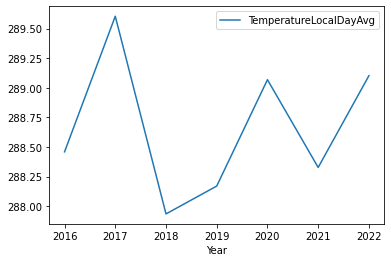

In [ ]:
ETO_series_temporales[(ETO_series_temporales["Year"]>2015) & (ETO_series_temporales["Month"]<7) & (ETO_series_temporales["Month"]>2)][["Year","TemperatureLocalDayAvg"]].groupby("Year").mean().plot()

<AxesSubplot:xlabel='CAMPAÑA'>

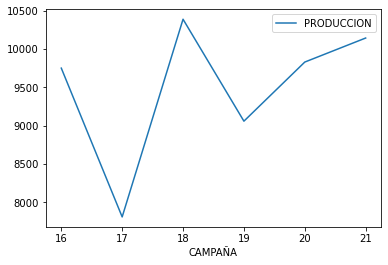

In [ ]:
train_bo[train_bo["CAMPAÑA"]<22][["CAMPAÑA","PRODUCCION"]].groupby("CAMPAÑA").mean().plot()

In [ ]:
ETO_GDD = ETO_series_temporales[["TemperatureLocalDayAvg","TemperatureLocalDayMax","TemperatureLocalDayMin","Year","Week","Month","ID_ESTACION"]]
#Pasamos a Celsius para poder calcular el índice, Tavg + Tmin
ETO_GDD["TemperatureLocalDayAvg"] = ETO_GDD["TemperatureLocalDayAvg"]-273.15  
ETO_GDD["TemperatureLocalDayMax"] = ETO_GDD["TemperatureLocalDayMax"]-273.15 
ETO_GDD["TemperatureLocalDayMin"] = ETO_GDD["TemperatureLocalDayMin"]-273.15
ETO_GDD["GDD"] = ((ETO_GDD["TemperatureLocalDayMax"]+ETO_GDD["TemperatureLocalDayMin"])/2 - 10)
ETO_GDD[ETO_GDD['GDD']<0]=0
ETO_GDD = ETO_GDD[(ETO_GDD["Week"]>12) & (ETO_GDD["Month"]<11)] #cuando empieza primavera
ETO_GDD = ETO_GDD.groupby(["ID_ESTACION","Year"]).agg(np.sum).reset_index()
ETO_GDD = ETO_GDD[["ID_ESTACION","Year","GDD"]]
ETO_GDD = ETO_GDD[ETO_GDD["Year"]>2015] #COGER FECHAS SIGNIFICATIVAS
ETO_GDD["Year"]=ETO_GDD["Year"]-2000 #IGUALAR AÑO CON CAMPAÑA
ETO_GDD.rename(columns={"Year":"CAMPAÑA"},inplace=True)

In [ ]:
ETO_series_temporales.drop(["TemperatureLocalDayMax","TemperatureLocalDayMin"],axis=1,inplace=True)

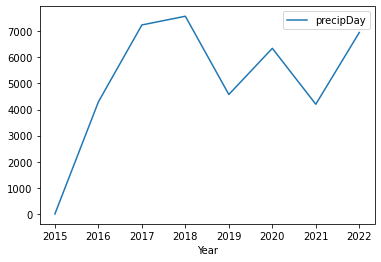

In [ ]:
ETO_Lluvia = ETO_series_temporales[["precipDay","Year","Month","ID_ESTACION"]]
mask1 = ETO_Lluvia["Month"]>10
ETO_Lluvia.loc[mask1, 'Year'] = ETO_Lluvia.loc[mask1]['Year']+1

ETO_Lluvia[ETO_Lluvia["Month"]<7][["Year","precipDay"]].groupby("Year").sum().plot()
ETO_Lluvia = ETO_Lluvia.groupby(["ID_ESTACION","Year","Month"]).agg(np.sum).reset_index()
#mask1 = ETO_Lluvia["Month"]>10
#ETO_Lluvia.loc[mask1, 'Year'] = ETO_Lluvia.loc[mask1]['Year']+1



ETO_Lluvia = ETO_Lluvia[(ETO_Lluvia["Year"]>2015) & (ETO_Lluvia["Year"]<2023)]
ETO_Lluvia = ETO_Lluvia.pivot_table("precipDay", ['Year', 'ID_ESTACION'], 'Month')

ETO_Lluvia.columns = ["Month_"+str(col) for col in ETO_Lluvia.columns.values]
ETO_Lluvia.reset_index(inplace=True)
ETO_Lluvia["Year"]=ETO_Lluvia["Year"]-2000
ETO_Lluvia.rename(columns={"Year":"CAMPAÑA"},inplace=True)

Visto el plot anterior de temperaturas y de precipitaciones, parece que la campaña 22 puede tener un comportamiento similar a la campaña 18 en cuanto a su afectación por temperaturas y precipitación. Por lo tanto, usaremos la campaña 18 en validación

Vamos a juntar las precipitaciones según el periodo donde se encuentra la vid. Marzo, abril y mayo son los meses de floración y brotación, junio, julio y agosto es una fase de crecimiento y setiembre y octubre es cuando madura y se hace la vendimia. Los demas meses la vid acumula reserva hídrica. Por lo tanto haremos estas cuatro divisiones.

In [ ]:
ETO_Lluvia["Precipitacion_Brotacion"] = ETO_Lluvia["Month_3"] +  ETO_Lluvia["Month_4"] + ETO_Lluvia["Month_5"]
ETO_Lluvia["Precipitacion_Crecimiento"] = ETO_Lluvia["Month_6"] +  ETO_Lluvia["Month_7"] + ETO_Lluvia["Month_8"]
ETO_Lluvia["Precipitacion_Maduracion"] = ETO_Lluvia["Month_9"] +  ETO_Lluvia["Month_10"]
ETO_Lluvia["Precipitacion_Reserva"] = ETO_Lluvia["Month_11"] +  ETO_Lluvia["Month_12"] + ETO_Lluvia["Month_1"] +  ETO_Lluvia["Month_2"]

In [ ]:
ETO_Lluvia=ETO_Lluvia[["CAMPAÑA","ID_ESTACION","Precipitacion_Reserva","Precipitacion_Maduracion","Precipitacion_Crecimiento","Precipitacion_Brotacion"]]

In [ ]:
ETO_series_temporales

,date,DewpointLocalDayAvg,EvapotranspirationLocalDayAvg,GlobalHorizontalIrradianceLocalDayAvg,RelativeHumidityLocalDayAvg,TemperatureLocalDayAvg,WindSpeedLocalDayMax,precipDay,ID_ESTACION,Year,Month,Week
0,2015-06-29,287.000000,0.200000,120.367500,39.600000,303.000000,4.800000,0.000000,0,2015,6,27
1,2015-06-30,285.000000,0.300000,349.241000,45.600000,299.000000,5.600000,0.000000,0,2015,6,27
2,2015-07-01,287.000000,0.300000,331.563500,52.700000,298.000000,6.700000,0.000000,0,2015,7,27
3,2015-07-02,289.000000,0.200000,310.846500,63.500000,297.000000,5.200000,0.000000,0,2015,7,27
4,2015-07-03,291.000000,0.200000,316.399000,70.700000,297.000000,6.400000,0.000000,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2022-11-02,280.770908,0.087830,122.539087,72.163906,287.153802,4.319124,1.198028,19,2022,11,44
2684,2022-11-03,280.493218,0.085569,124.065477,71.507518,287.044332,4.240128,1.236683,19,2022,11,44
2685,2022-11-04,280.386641,0.087032,121.402051,71.282764,287.043455,4.335409,0.731702,19,2022,11,44
2686,2022-11-05,279.948929,0.088237,123.625131,70.226877,286.837865,4.378040,0.695824,19,2022,11,44


In [ ]:
ETO_series_temporales.drop(["precipDay","Week"],axis=1,inplace=True)

Nos queda por añadir el punto de rocío, la evatransporación, la humedad relativa y la velocidad máxima media, que son valores que podrian llegar a afectar. Estos parámetros solo son relevantes en las épocas donde la vid tiene hoja, es decir de marzo a octubre.

In [ ]:
ETO_series_temporales
ETO_series_temporales = ETO_series_temporales[(ETO_series_temporales["Month"]>2) & (ETO_series_temporales["Month"]<11)]
ETO_Clima = ETO_series_temporales.groupby(["ID_ESTACION","Year","Month"]).agg(np.mean).reset_index()

In [ ]:
ETO_Clima = ETO_Clima[(ETO_Clima["Year"]>2015) & (ETO_Clima["Year"]<2023)]


def modify_data(feature):
    data = ETO_Clima.pivot_table(feature, ['Year', 'ID_ESTACION'], 'Month')
    data.columns = ["Month_"+str(col) for col in data.columns.values]
    data.reset_index(inplace=True)
    data["Year"]=data["Year"]-2000

    data.rename(columns={"Year":"CAMPAÑA"},inplace=True)
    return data

ETO_Temperatura = modify_data("TemperatureLocalDayAvg")
ETO_Rocio = modify_data("DewpointLocalDayAvg")
ETO_Ev = modify_data("EvapotranspirationLocalDayAvg")
ETO_Viento = modify_data("WindSpeedLocalDayMax")
ETO_Humedad = modify_data("RelativeHumidityLocalDayAvg")
ETO_Radiacion = modify_data("GlobalHorizontalIrradianceLocalDayAvg")

In [ ]:
ETO_Temperatura["Temperatura_Brotacion"] = (ETO_Temperatura["Month_3"] +  ETO_Temperatura["Month_4"] + ETO_Temperatura["Month_5"])/3
ETO_Temperatura["Temperatura_Crecimiento"] = (ETO_Temperatura["Month_6"] +  ETO_Temperatura["Month_7"] + ETO_Temperatura["Month_8"] )/3
ETO_Temperatura["Temperatura_Maduracion"] = (ETO_Temperatura["Month_9"] +  ETO_Temperatura["Month_10"])/2

ETO_Temperatura=ETO_Temperatura[["CAMPAÑA","ID_ESTACION","Temperatura_Brotacion","Temperatura_Crecimiento","Temperatura_Maduracion"]]

ETO_Rocio["Rocio_Brotacion"] = (ETO_Rocio["Month_3"] +  ETO_Rocio["Month_4"] + ETO_Rocio["Month_5"])/3
ETO_Rocio["Rocio_Crecimiento"] = (ETO_Rocio["Month_6"] +  ETO_Rocio["Month_7"] + ETO_Rocio["Month_8"] )/3
ETO_Rocio["Rocio_Maduracion"] = (ETO_Rocio["Month_9"] +  ETO_Rocio["Month_10"])/2

ETO_Rocio=ETO_Rocio[["CAMPAÑA","ID_ESTACION","Rocio_Maduracion","Rocio_Crecimiento","Rocio_Brotacion"]]

ETO_Ev["Ev_Brotacion"] = (ETO_Ev["Month_3"] +  ETO_Ev["Month_4"] + ETO_Ev["Month_5"])/3
ETO_Ev["Ev_Crecimiento"] = (ETO_Ev["Month_6"] +  ETO_Ev["Month_7"] + ETO_Ev["Month_8"])/3
ETO_Ev["Ev_Maduracion"] = (ETO_Ev["Month_9"] +  ETO_Ev["Month_10"])/2

ETO_Ev=ETO_Ev[["CAMPAÑA","ID_ESTACION","Ev_Brotacion","Ev_Crecimiento","Ev_Maduracion"]]

ETO_Viento["Viento_Brotacion"] = (ETO_Viento["Month_3"] +  ETO_Viento["Month_4"] + ETO_Viento["Month_5"])/3
ETO_Viento["Viento_Crecimiento"] = ( ETO_Viento["Month_6"] +  ETO_Viento["Month_7"] + ETO_Viento["Month_8"])/3
ETO_Viento["Viento_Maduracion"] = ( ETO_Viento["Month_9"] +  ETO_Viento["Month_10"])/2

ETO_Viento=ETO_Viento[["CAMPAÑA","ID_ESTACION","Viento_Brotacion","Viento_Crecimiento","Viento_Maduracion"]]

ETO_Humedad["Humedad_Brotacion"] = (ETO_Humedad["Month_3"] +  ETO_Humedad["Month_4"] + ETO_Humedad["Month_5"])/3
ETO_Humedad["Humedad_Crecimiento"] = (ETO_Humedad["Month_6"] +  ETO_Humedad["Month_7"] + ETO_Humedad["Month_8"])/3
ETO_Humedad["Humedad_Maduracion"] = (ETO_Humedad["Month_9"] +  ETO_Humedad["Month_10"])/2

ETO_Humedad=ETO_Humedad[["CAMPAÑA","ID_ESTACION","Humedad_Brotacion","Humedad_Crecimiento","Humedad_Maduracion"]]

ETO_Radiacion["Radiacion_Brotacion"] = (ETO_Radiacion["Month_3"] +  ETO_Radiacion["Month_4"] + ETO_Radiacion["Month_5"])/3
ETO_Radiacion["Radiacion_Crecimiento"] = (ETO_Radiacion["Month_6"] +  ETO_Radiacion["Month_7"] + ETO_Radiacion["Month_8"])/3
ETO_Radiacion["Radiacion_Maduracion"] = (ETO_Radiacion["Month_9"] +  ETO_Radiacion["Month_10"])/2

ETO_Radiacion=ETO_Radiacion[["CAMPAÑA","ID_ESTACION","Radiacion_Brotacion","Radiacion_Crecimiento","Radiacion_Maduracion"]]


### Modelos

Podemos empezar a hacer modelos con los datos climatológicos

#### RandomForest

Empezamos con un RandomForest, añadiendo los datos climatológicos uno a uno. Aquellos comentados son los que no ayudan a mejorar el modelo.

In [ ]:
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
#train_dataset = train_dataset.join(pd.get_dummies(train_dataset.VARIEDAD,"VARIEDAD"))
#train_dataset= train_dataset.merge(ETO_GDD,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Temperatura,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Rocio,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Ev,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Humedad,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]<21) & (train_dataset["CAMPAÑA"]!=18)]

val_set_data = train_dataset[train_dataset["CAMPAÑA"]==21]
val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

X_test_21 = val_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_21 = val_set_data["PRODUCCION"]
X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]
#De manera empírica hemos visto que quitando los valores del train superiores a
#este valor mejora (y bastante) el modelo
train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6] 
pred_set = pred_set_data.drop("PRODUCCION",axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]

regr = RandomForestRegressor(n_estimators = 200,max_depth=25, random_state=0, n_jobs=-1)
regr.fit(X_train,y_train)
prediccio = regr.predict(X_test_21)
print(f'R2 Score Baseline 21: {r2_score(y_test_21,prediccio)}')
print(f'MSE Baseline 21: {mean_squared_error(y_test_21,prediccio,squared=False)}')
prediccio2 = regr.predict(X_test_18)
print(f'R2 Score Baseline 18: {r2_score(y_test_18,prediccio2)}')
print(f'MSE Baseline 18: {mean_squared_error(y_test_18,prediccio2,squared=False)}')

R2 Score Baseline 21: 0.9138812433769726
MSE Baseline 21: 4021.289846038926
R2 Score Baseline 18: 0.8942126794026851
MSE Baseline 18: 4856.993759749485


In [ ]:
#RMSE de 18 con Estimación
np.sqrt(np.mean((X_test_18["ESTIMACION_PRODUCCION"]- y_test_18)**2))

4867.053141232502

In [ ]:
#RMSE de 21 con Estimación
np.sqrt(np.mean((X_test_21["ESTIMACION_PRODUCCION"]- y_test_21)**2))

Vemos que mejora el baseline, y además en el caso de la campaña 18 hace una mejor aproximación que la hecha con la estimación (en la campaña 21 era esperable que no mejorara). Por lo tanto da resultados prometedores

#### XGBoost

Proseguimos con el XGBoost, otro modelo muy usado para estos casos.

In [ ]:
from xgboost import XGBRegressor

train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
#train_dataset = train_dataset.join(pd.get_dummies(train_dataset.VARIEDAD,"VARIEDAD"))
#train_dataset= train_dataset.merge(ETO_GDD,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Temperatura,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Rocio,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Ev,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
#train_dataset= train_dataset.merge(ETO_Humedad,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]<21) & (train_dataset["CAMPAÑA"]!=18)]

val_set_data = train_dataset[train_dataset["CAMPAÑA"]==21]
val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

X_test_21 = val_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_21 = val_set_data["PRODUCCION"]
X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]

regressor = XGBRegressor(n_estimators=80, max_depth=3, eta=0.1, subsample=0.7, colsample_bytree=0.7,booster='gbtree',
                        min_child_weight =3,tree_method="exact",reg_lambda=1,objective = "reg:squarederror",
                         eval_metric = "rmse")
# Training the model
regressor.fit(X_train, y_train)
y_pred_21 = regressor.predict(X_test_21)
y_pred_18 = regressor.predict(X_test_18)

r2_score_21 = r2_score(y_test_21, y_pred_21)
mse_21 = mean_squared_error(y_test_21, y_pred_21, squared=False)

# print results
print(f'R2 Score 21: {r2_score_21}')
print(f'MSE 21: {mse_21}')

# calculate evaluation metrics
r2_score_18 = r2_score(y_test_18, y_pred_18)
mse_18 = mean_squared_error(y_test_18, y_pred_18, squared=False)

# print results
print(f'R2 Score 18: {r2_score_18}')
print(f'MSE 18: {mse_18}')

R2 Score 21: 0.9228025812845495
MSE 21: 3807.3069469108027
R2 Score 18: 0.8977600431027133
MSE 18: 4774.864652629167


Vemos que el XGBoost da resultados incluso mejores que el RandomForest, y por lo tanto lo tendremos en cuenta de cara al GridSearch

#### KNN

Finalmente, probamos con un KNN, para ver como predice teniendo en cuenta los valores de estimación y la superfície

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]<21) & (train_dataset["CAMPAÑA"]!=18)]

val_set_data = train_dataset[train_dataset["CAMPAÑA"]==21]
val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ZONA","ID_ESTACION"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)



#X_test_21 = val_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION","VARIEDAD"],axis=1)
X_test_21 = val_set_data[["ESTIMACION_PRODUCCION","SUPERFICIE"]]
y_test_21 = val_set_data["PRODUCCION"]
#X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION","VARIEDAD"],axis=1)
X_test_18 = val_set_data_1[["ESTIMACION_PRODUCCION","SUPERFICIE"]]
X_test_copy = X_test_18.copy()
y_test_18 = val_set_data_1["PRODUCCION"]

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

#X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION","VARIEDAD"],axis=1)
X_train = train_set_data[["ESTIMACION_PRODUCCION","SUPERFICIE"]]
y_train = train_set_data["PRODUCCION"]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test_21 = scaler.transform(X_test_21)
X_test_18 = scaler.transform(X_test_18)
neigh = KNeighborsRegressor(n_neighbors=7).fit(X_train,y_train)

y_pred_21 = neigh.predict(X_test_21)
y_pred_18 = neigh.predict(X_test_18)

r2_score_21 = r2_score(y_test_21, y_pred_21)
mse_21 = mean_squared_error(y_test_21, y_pred_21, squared=False)

# print results
print(f'R2 Score 21: {r2_score_21}')
print(f'MSE 21: {mse_21}')

# calculate evaluation metrics
r2_score_18 = r2_score(y_test_18, y_pred_18)
mse_18 = mean_squared_error(y_test_18, y_pred_18, squared=False)

# print results
print(f'R2 Score 18: {r2_score_18}')
print(f'MSE 18: {mse_18}')

R2 Score 21: 0.9154161130748732
MSE 21: 3985.2935941843016
R2 Score 18: 0.881970367392909
MSE 18: 5130.341377925623


Si bien es cierto que mejora el baseline, su mejora esta muy limitada en el gridSearch y por lo tanto lo descartamos de cara al Hyperparameter Tunning

### Hyperparameter Search

#### RandomForest

Empezamos con el RandomForest

In [ ]:
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]!=18)]

val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]


Hacemos un RandomSearch para encontrar los valores óptimos del RandomForest acorde al set de train del 2018

In [ ]:
n_estimators = [150,200,300]
max_depth = [25,30,35]
min_samples_split = [4,5,6]


# Mínimo grande inicial
minimo_18 = 999999 
params_18 = 0
# Número de iteraciones para el random search
iterations = 80
for i in range(iterations):
    params = {}
    params['n_estimators'] = np.random.choice(n_estimators)
    params['max_depth'] = np.random.choice(max_depth)
    params['min_samples_split'] = np.random.choice(min_samples_split)

    regr = RandomForestRegressor(**params,n_jobs=-1,random_state=0)
    regr.fit(X_train,y_train)
    
    y_pred_18 = regr.predict(X_test_18)


    # calculate evaluation metrics
    #r2_score_18 = r2_score(y_test_18, y_pred_18)
    mse_18 = mean_squared_error(y_test_18, y_pred_18, squared=False)
        
        
    if mse_18 < minimo_18:
        minimo_18 = mse_18
        params_18 = params 


print("*" * 50)
print('Minimum 18 is: ', minimo_18)
print('Used params 18', params_18)

**************************************************
Minimum 18 is:  4758.167157982671
Used params 18 {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 6}


#### XGBoost

Proseguimos con el XGBoost igual

In [ ]:
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Temperatura,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]!=18)]

val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]




In [ ]:
n_estimators = [50,80,90,100,200]
min_child_weight = [2,3,4,5]
reg_lambda= [0.8,1]
max_depth = [3,4,5]
subsample =[0.7]
colsample =[0.7]
# Mínimo grande inicial
minimo_18 = 999999 
params_18 = 0
# Número de iteraciones para el random search
iterations = 700

for i in range(iterations):
    params = {}
    params['n_estimators'] = np.random.choice(n_estimators)
    params['min_child_weight'] = np.random.choice(min_child_weight)
    params['max_depth'] = np.random.choice(max_depth)
    params['subsample'] = np.random.choice(subsample)
    params['colsample_bytree'] = np.random.choice(colsample)
    params['reg_lambda'] = np.random.choice(reg_lambda)




    regr = XGBRegressor(**params,booster='gbtree',eta=0.1, tree_method="exact",objective = "reg:squarederror",
                         eval_metric = "rmse").fit(X_train,y_train)
    
    
    y_pred_18 = regr.predict(X_test_18)


    # calculate evaluation metrics
    #r2_score_18 = r2_score(y_test_18, y_pred_18)
    mse_18 = mean_squared_error(y_test_18, y_pred_18, squared=False)
        
        
    if mse_18 < minimo_18:
        minimo_18 = mse_18
        params_18 = params 


print("*" * 50)
print('Minimum 18 is: ', minimo_18)
print('Used params 18', params_18)


**************************************************
Minimum 18 is:  4870.004987536425
Used params 18 {'n_estimators': 90, 'min_child_weight': 5, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 0.8}


### Ensemble de modelos

Tenemos los valores optimos para nuestro RandomForest y XGBoost, además de la predicción en base a la estimación. Vamos a mirar que combinación de ellos nos propicia el mejor resultado para la campaña del 18. Primero obtenemos la predicción final de nuestros modelos con estos hiperparámetros.

In [ ]:
#PREDICCIÓN RANDOMFOREST
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]!=18)]#& (train_dataset["CAMPAÑA"]<21)]

val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]

regr = RandomForestRegressor(n_estimators = 300,max_depth=25, min_samples_split =6, random_state=0, n_jobs=-1)
regr.fit(X_train,y_train)
prediccio_rf = regr.predict(X_test_18)


In [ ]:
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Temperatura,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]!=18)]

val_set_data_1 = train_dataset[train_dataset["CAMPAÑA"]==18]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]
train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
val_set_data_1.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)
pred_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

X_test_18 = val_set_data_1.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_test_18 = val_set_data_1["PRODUCCION"]

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop("PRODUCCION",axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]

regr = XGBRegressor(n_estimators = 90,reg_lambda=0.8,min_child_weight=5,subsample = 0.7,colsample_bytree=0.7,booster='gbtree',eta=0.1,max_depth=3, tree_method="exact",objective = "reg:squarederror",
                         eval_metric = "rmse").fit(X_train,y_train)
    
    
prediccio_xgb = regr.predict(X_test_18)



In [ ]:
prediccio_estimacio = X_test_18["ESTIMACION_PRODUCCION"]

In [ ]:
rmse = []
pesos = []
for i in np.arange(0.0, 1.0, 0.01):
    for j in np.arange(0.0, 1.0, 0.01):
        for k in np.arange(0.0, 1.0, 0.01):
            if np.isclose(1, i+j+k):
                resultado = prediccio_estimacio * i + prediccio_xgb * j + prediccio_rf * k
                valor_rmse =  np.sqrt(np.mean((resultado - y_test_18)**2))
                rmse.append(valor_rmse)
                pesos.append([i,j,k])

In [ ]:
mejor_combinacion = rmse.index(np.array(rmse).min())
print(pesos[mejor_combinacion], rmse[mejor_combinacion])

[0.18, 0.14, 0.68] 4735.909763995682


<AxesSubplot:>

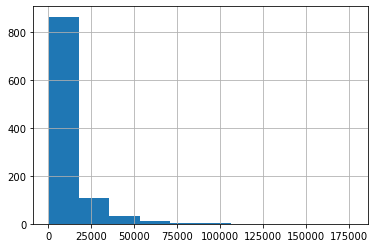

In [ ]:
y_test_18.hist()

### Prediccion Final

In [ ]:
#PREDICCIÓN RANDOMFOREST
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]<22)]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]

train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION","CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]


regr = RandomForestRegressor(n_estimators = 300,max_depth=25, min_samples_split =6, random_state=0, n_jobs=-1)
regr.fit(X_train,y_train)
prediccion_rf = regr.predict(pred_set)


In [ ]:
#PREDICCIÓN XGBOOST
train_dataset = train_bo[(train_bo["CAMPAÑA"]>15)]
train_dataset = train_dataset.merge(ETO_Lluvia,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Temperatura,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Viento,how="left",on=["CAMPAÑA","ID_ESTACION"])
train_dataset= train_dataset.merge(ETO_Radiacion,how="left",on=["CAMPAÑA","ID_ESTACION"])

train_set_data = train_dataset[(train_dataset["CAMPAÑA"]<22)]
pred_set_data = train_dataset[train_dataset["CAMPAÑA"]==22]

train_set_data.drop(["CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1,inplace=True)

train_set_data = train_set_data[np.abs(train_set_data["FACTOR_PRODUCCION"])<1.6]

pred_set = pred_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION","CAMPAÑA","ID_FINCA","ID_ESTACION","ID_ZONA"],axis=1)

X_train = train_set_data.drop(["PRODUCCION","FACTOR_PRODUCCION"],axis=1)
y_train = train_set_data["PRODUCCION"]


regr = XGBRegressor(n_estimators = 90,reg_lambda=0.8,min_child_weight=5,subsample = 0.7,colsample_bytree=0.7,booster='gbtree',eta=0.1,max_depth=3, tree_method="exact",objective = "reg:squarederror",
                         eval_metric = "rmse").fit(X_train,y_train)
    
prediccion_xgb = regr.predict(pred_set)

In [ ]:
prediccion_estimacion = pred_set["ESTIMACION_PRODUCCION"]

In [ ]:
prediccion_final = 0.18 * prediccion_estimacion + 0.14 * prediccion_xgb + 0.68 * prediccion_rf

Vemos que el histograma es parecido al de la campaña 18, por lo tanto esperaríamos resultados parecidos

In [ ]:
prediccion_final.hist()

### Entrega

In [ ]:
pred_set_data["PRODUCCION"] = prediccion_final

In [ ]:
entrega = pred_set_data[["ID_FINCA","VARIEDAD","MODO","TIPO","COLOR","SUPERFICIE","PRODUCCION"]]

In [ ]:
entrega = entrega.sort_values(["ID_FINCA","VARIEDAD","MODO","TIPO","COLOR","SUPERFICIE","PRODUCCION"])

In [ ]:
entrega["MODO"] = entrega["MODO"]+1
entrega["PRODUCCION"]=entrega["PRODUCCION"].round(2)
entrega["SUPERFICIE"]=entrega["SUPERFICIE"].round(2)

entrega.to_csv("SOFIS-ticados.txt",index=False,header=False,sep = "|")